<a href="https://colab.research.google.com/github/A00785001/TC5035/blob/main/004-Loop_Closure_Dataset_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loop Closure Dataset Generation: Time Alignment, Pairing & Labeling
## Phase 1.5: Supervised Learning Dataset Preparation for Jetson Nano Training Pipeline

**Version:** 6.10  
**Pipeline Phase:** Feature Extraction → **[THIS NOTEBOOK]** → Fusion MLP Training → Deployment  
**Target Hardware:** Waveshare Jetbot AI Pro Kit (Jetson Nano)  
**SLAM System:** Google Cartographer (2D)  
**Training Platform:** Vertex AI

---

---

# DOCUMENTATION

---



## NOTEBOOK DOCUMENTATION

### Purpose

This notebook transforms independently extracted multi-modal features (camera + LiDAR) into a supervised learning dataset for training a loop closure detection classifier. It bridges the gap between feature extraction and neural network training by performing temporal alignment, intelligent pairing, and ground truth labeling.

---

### Workflow Overview

**Phase 1A:** ROS Bag Validation (optional validation)
**Phase 1B:** Feature File Validation (HDF5 features)
**Phase 1C:** Pbstream Extraction
- Extract trajectory nodes with timestamps and poses
- Extract INTER_SUBMAP constraints (loop closures)
- Generate pairwise distance/time table for all nodes
- Temporal alignment: Match features to trajectory nodes

**Phase 2:** Dataset Generation
- Data profiling and automatic threshold suggestion
- Generate positive pairs (loop closures from distance + time filters)
- Generate easy negative pairs (spatially distant)
- Generate hard negative pairs (perceptually similar but distant)

**Phase 3:** Dataset Splitting & Validation
**Phase 4:** Save Dataset & Generate Report

---

### Folder Structure

**Expected Directory Layout:**

```
session_YYYYMMDD_HHMMSS/          (base working folder - your session)
├── map.pbstream                  ← INPUT: Cartographer pbstream file (REQUIRED)
├── session_data.bag              ← INPUT: ROS bag file (optional validation)
├── features/                     ← INPUT: Directory from feature extraction
│   └── features.h5               ← INPUT: Extracted features (HDF5)
└── dataset/                      ← OUTPUT: Created by this notebook
    ├── loop_closure_dataset.pkl  ← OUTPUT: Training dataset
    ├── dataset_diagnostics.png   ← OUTPUT: Visualization plots
    └── dataset_generation_report.txt ← OUTPUT: Summary report
```

**Note:** The `.pbstream` file is REQUIRED. Replace `session_YYYYMMDD_HHMMSS` with your actual session folder name.

---

### Required Inputs

#### 1. Pbstream File (REQUIRED)

**File:** `map.pbstream` (Cartographer SLAM state)

**Contents:**
- Trajectory nodes with full 6-DOF poses and timestamps
- INTER_SUBMAP constraints (loop closures detected by SLAM)
- Complete SLAM graph state

#### 2. Extracted Features (HDF5 Format)

**File:** `features/features.h5` (generated from feature extraction pipeline)

**Structure:**
```
features.h5
├── camera/
│   ├── features [N_cam, 1280]       # MobileNetV2 embeddings (L2 normalized, float32)
│   ├── timestamps_sec [N_cam]       # ROS timestamp seconds (int64)
│   ├── timestamps_nsec [N_cam]      # ROS timestamp nanoseconds (int32)
│   └── filenames [N_cam]            # Source image filenames (strings)
└── lidar/
    ├── features [N_lid, 256]        # 1D CNN descriptors (L2 normalized, float32)
    ├── timestamps_sec [N_lid]       # ROS timestamp seconds (int64)
    ├── timestamps_nsec [N_lid]      # ROS timestamp nanoseconds (int32)
    └── filenames [N_lid]            # Source scan filenames (strings)
```

---


---

## 🧠 HOW THIS NOTEBOOK WORKS: COMPREHENSIVE EXPLANATION

### The Problem We're Solving

**Loop closure detection** is critical for mobile robot SLAM. When a robot revisits a location, the system must recognize this "loop closure" to correct accumulated drift. This notebook creates a **supervised learning dataset** to train a neural network for loop closure detection using multi-modal sensor data.

**The Challenge:** Three independent data streams must be combined:
- Camera features (1280D MobileNetV2) at ~0.22 Hz
- LiDAR features (256D 1D-CNN) at ~0.7 Hz  
- SLAM ground truth (Cartographer trajectory + constraints)

These have **different rates**, **independent timestamps**, and **no pre-sync**.

---

### Why This Approach?

#### **1. Why INTER_SUBMAP Constraints?**

Cartographer's pose graph has two constraint types:
- **INTRA_SUBMAP**: Sequential (node j inserted into submap i)
- **INTER_SUBMAP**: Loop closures (node j NOT in submap i = robot returned)

**INTER_SUBMAP = gold standard** because:
- Cartographer solved loop closure via scan matching
- Passed rigorous geometric validation
- Verified spatial alignment (<2m, similar orientation)
- Residual provides confidence metric

#### **2. Why KD-Trees for Temporal Alignment?**

**Sensors operate independently:**
- Camera: ~4.5s intervals
- LiDAR: ~1.4s intervals
- Trajectory nodes: ~0.9 Hz

**KD-Tree solution:** O(log N) nearest-neighbor in time domain
```
For node at time T:
  → Find camera where |t_cam - T| < 0.5s
  → Find LiDAR where |t_lid - T| < 0.5s
  → Combine into multi-modal feature
```

**±700ms threshold** balances:
- Robot motion (~0.5m in 700ms at low speed)
- Sensor rate limits
- Pose uncertainty

#### **3. Why Three Pair Types?**

**Positive (30%)** - True loop closures from INTER_SUBMAP
- Teaches "same place" recognition

**Easy Negative (35%)** - Distance >5m + temporal gap >5s
- Teaches basic discrimination
- Temporal gap prevents consecutive-but-far frames

**Hard Negative (35%)** - High similarity (>0.7) BUT distant (>3m)
- Handles perceptual aliasing (corridors, symmetry)
- Most challenging cases

**Balanced 30/35/35** prevents:
- Trivial solutions ("always no")
- Easy case overfitting
- Perceptual aliasing failure

---

### Step-by-Step Workflow

#### **PHASE 0: Data Validation**

**HDF5 Analysis (1.1.5):** Feature stats, temporal coherence, quality checks
**Bag Analysis (1.2.5):** Trajectory distribution, INTER constraints, overlap

#### **PHASE 1: Feature-Trajectory Alignment**

**Step 1.1: Load Features**
```
camera_features: [N, 1280] L2-normalized
lidar_features: [N, 256] L2-normalized
timestamps: sec (int64) + nsec (int32)
```

**Step 1.2: Parse Trajectory Nodes**
```
From /trajectory_node_list (MarkerArray):
  node_id, timestamp, pose (x,y,z, qx,qy,qz,qw)
```

**Step 1.2.6: Parse INTER_SUBMAP Constraints**
```
From /constraint_list (MarkerArray):
  Filter: "Inter constraints" namespace only
  Match: constraint endpoints → trajectory nodes
  Validate: distance <2m, angle <90°, residual <0.5m
```

**Step 1.3: Temporal Alignment**
```
For each trajectory node at time T:
  cam_idx = nearest(camera_times, T) if |diff| < 0.5s
  lid_idx = nearest(lidar_times, T) if |diff| < 0.5s
  
  If both found:
    combined_feature = [cam_feat, lid_feat]  # [1536D]
    valid_nodes.append(node)
```

#### **PHASE 2: Intelligent Pairing**

**Step 2.1: Positive Pairs**
```
For (node_i, node_j) in INTER_SUBMAP_constraints:
  If both have combined_feature:
    pair = {features: [feat_i, feat_j], label: 1}
```

**Step 2.2: Easy Negatives**
```
Random sample nodes:
  Accept if: distance >5m AND time_gap >5s
```

**Step 2.3: Hard Negatives**
```
KD-Tree in feature space:
  Find similar features (cosine >0.7)
  Accept if: spatially distant (>3m)
```

#### **PHASE 3: Finalization**

- Combine + shuffle all pairs
- Stratified train/val/test split (60/20/20)
- Validation checks + statistics
- Save PKL + diagnostics + report

---

### 🛡️ Key Design Decisions

**±700ms threshold:**
- Too tight (<100ms): 60-80% data loss
- Too loose (>1s): Robot moves >1m, high uncertainty
- Sweet spot (700ms): <0.5m motion at low speed, better alignment coverage

**Float64 for timestamps:**
- Precision loss: ~250ns
- Threshold: 700,000,000ns
- Ratio: 5e-7 (negligible!)
- Store both: split (exact) + float (algorithms)

**Residual <0.5m filter:**
- High residual = weak constraint
- Filters false positives
- Keeps only high-quality ground truth

**35/35 easy/hard split:**
- Only easy: fails on aliasing
- Only hard: won't converge
- Balanced: stable training + generalization

**L2 normalization required:**
- Enables cosine similarity = dot product
- Network learns directions not magnitudes
- KD-tree works in normalized space

---

### ⚠️ Common Issues

**"No INTER_SUBMAP constraints"**
- Robot never looped back
- Solution: Re-record with intentional loops

**"Low alignment <50%"**
- Clock skew or wrong timestamps
- Solution: Verify bag recording, check timestamps

**"Features not normalized"**
- Extraction pipeline error
- Solution: Re-extract with normalization

**"Insufficient positives"**
- Too few validated constraints
- Solution: Relax thresholds or re-record

---

### Next Steps

**Output:** `loop_closure_dataset.pkl`
```
{'train': {features: [N,2,1536], labels: [N]},
 'val': {...},
 'test': {...},
 'config': {...},
 'statistics': {...}}
```

**1. Train Fusion MLP (Vertex AI)**
- Input: [2, 1536] paired features
- Architecture: MLP with dropout
- Output: Binary classifier

**2. Evaluate**
- Precision/Recall/F1
- ROC curves
- Per-type accuracy

**3. Deploy to Jetson Nano**
- TensorRT optimization
- Real-time inference (<50ms)
- Integrate with Cartographer

---

---

# SECTION 1: SETUP

Imports, configuration, thresholds.

---



## 1.1 IMPORTS AND DEPENDENCIES

In [43]:
# Install required packages
!pip install -q rosbags h5py scikit-learn matplotlib

print("✅ All packages installed successfully")

✅ All packages installed successfully


In [44]:
# System and file I/O
import os
import sys
import pickle
from pathlib import Path
import struct
import zlib
from google.protobuf.internal.decoder import _DecodeVarint32, _DecodeVarint
from google.colab import drive

# Numerical computing
import numpy as np
from scipy.spatial import KDTree
from scipy.spatial.transform import Rotation
# Data handling
import h5py
import pandas as pd # Added pandas import
# ROS bag processing
from rosbags.rosbag1 import Reader
from rosbags.typesys import get_typestore, Stores
# Visualization
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import seaborn as sns
# Progress tracking
from tqdm import tqdm
# Random state for reproducibility
import random
print("✅ All imports successful")
print(f"   NumPy version: {np.__version__}")
print(f"   Python version: {sys.version.split()[0]}")

✅ All imports successful
   NumPy version: 2.0.2
   Python version: 3.12.12


## 1.2 WORKING DIRECTORY CONFIGURATION

---

# SECTION 2: STORAGE MOUNTING

Google Drive mount.

---



In [45]:
# Detect environment
try:
    import google.colab
    IN_COLAB = True
    print(" Running in Google Colab")
except ImportError:
    IN_COLAB = False
    print(" Running in local environment")

# Mount Google Drive if in Colab
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    print("✅ Google Drive mounted")



 Running in Google Colab
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive mounted


In [46]:
# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
print(f"\n Random seed set to: {RANDOM_SEED}")

# Time alignment parameters
MAX_TIME_OFFSET = 0.7  # seconds - maximum time difference for feature-node matching
MIN_TEMPORAL_GAP = 5.0  # seconds - minimum time between frames for negative pairs

# Spatial thresholds
POSITIVE_DISTANCE_THRESHOLD = 0.3  # meters - UPDATED for 3m x 2m environment
EASY_NEGATIVE_MIN_DISTANCE = 1.0  # meters - UPDATED for small indoor space
HARD_NEGATIVE_MIN_DISTANCE = 3.0  # meters - minimum distance for hard negatives

POSITIVE_TIME_GAP = 10.0  # seconds - minimum time between loop closure pairs
# Cartographer validation thresholds
MAX_CONSTRAINT_RESIDUAL = 0.5  # meters - maximum constraint error for validation
MAX_ANGULAR_DISTANCE = np.pi / 2  # radians - maximum angular difference for loop closure

# Pairing strategy - Option 2: Hard-focused ratios (relative to positive count)
EASY_NEGATIVE_RATIO = 0.75   # 0.75x positives (22% of final dataset)
HARD_NEGATIVE_RATIO = 1.25   # 1.25x positives (48% of final dataset)
# Positives will be 30% of final dataset

# Hard negative mining
HARD_NEGATIVE_SIMILARITY_THRESHOLD = 0.7  # cosine similarity threshold for perceptual aliasing
HARD_NEGATIVE_SIMILARITY_FALLBACK = [0.7, 0.65, 0.6, 0.55]  # Fallback thresholds if insufficient hard negatives

# Easy negative sampling
EASY_NEG_MIN_TEMPORAL_GAP = 5.0  # seconds - minimum time gap for easy negatives
STRATIFY_DISTANCE_BINS = [1.0, 1.5, 2.0, np.inf]  # meters - distance bins for stratified sampling
# Split ratios (stratified random)
TRAIN_RATIO = 0.60
VAL_RATIO = 0.20
TEST_RATIO = 0.20

print("\n⚙️ Algorithm Parameters:")
print(f"  Time alignment: ±{MAX_TIME_OFFSET}s")
print(f"  Positive threshold: <{POSITIVE_DISTANCE_THRESHOLD}m")
print(f"  Easy negative: >{EASY_NEGATIVE_MIN_DISTANCE}m")
print(f"  Hard negative: >{HARD_NEGATIVE_MIN_DISTANCE}m, similarity >{HARD_NEGATIVE_SIMILARITY_THRESHOLD}")
print(f"  Constraint validation: residual <{MAX_CONSTRAINT_RESIDUAL}m, angle <{MAX_ANGULAR_DISTANCE:.2f} rad")
print(f"  Negative sampling ratios: {EASY_NEGATIVE_RATIO:.2f}x easy / {HARD_NEGATIVE_RATIO:.2f}x hard (relative to positives)")
print(f"  Split ratios: {TRAIN_RATIO:.0%} train / {VAL_RATIO:.0%} val / {TEST_RATIO:.0%} test")


 Random seed set to: 42

⚙️ Algorithm Parameters:
  Time alignment: ±0.7s
  Positive threshold: <0.3m
  Easy negative: >1.0m
  Hard negative: >3.0m, similarity >0.7
  Constraint validation: residual <0.5m, angle <1.57 rad
  Negative sampling ratios: 0.75x easy / 1.25x hard (relative to positives)
  Split ratios: 60% train / 20% val / 20% test


In [47]:
# Configure session folder
SESSION_ID = 'session_20251022_155137'  # ← CHANGE THIS to your session folder name

if IN_COLAB:
    # Google Colab: Assume data is in Drive
    BASE_PATH = f'/content/drive/MyDrive/DATA/Artificial_Intelligence/MNA-V/Subjects/TC5035-Proyecto_Integrador/TC5035.data/jetbot/{SESSION_ID}'
else:
    # Local: Use current directory or specify path
    BASE_PATH = f'./{SESSION_ID}'  # Or specify full path: '/path/to/data/{SESSION_ID}'

# Change to working directory
os.chdir(BASE_PATH)
print(f"\n Working directory: {os.getcwd()}")
print(f"   Session ID: {SESSION_ID}")


 Working directory: /content/drive/MyDrive/DATA/Artificial_Intelligence/MNA-V/Subjects/TC5035-Proyecto_Integrador/TC5035.data/jetbot/session_20251022_155137
   Session ID: session_20251022_155137


In [48]:
# File Paths Configuration
print("=" * 70)
print("FILE PATHS CONFIGURATION")
print("=" * 70)

# Input directories and files (relative to working folder)
FEATURES_DIR = 'features'
FEATURES_FILE = os.path.join(FEATURES_DIR, 'features.h5')
BAG_FILE = 'session_data.bag'  # In base working folder
PBSTREAM_FILE = 'map.pbstream'  # Optional, in base working folder

# Output directory for dataset
OUTPUT_DIR = 'dataset'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Output files
DATASET_FILE = os.path.join(OUTPUT_DIR, 'loop_closure_dataset.pkl')
DIAGNOSTICS_FILE = os.path.join(OUTPUT_DIR, 'dataset_diagnostics.png')
REPORT_FILE = os.path.join(OUTPUT_DIR, 'dataset_generation_report.txt')

print("\n Input Configuration:")
print(f"  Features directory: {FEATURES_DIR}")
print(f"  Features file: {FEATURES_FILE}")
print(f"  ROS bag file: {BAG_FILE}")
print(f"  Pbstream file: {PBSTREAM_FILE}")

print("\n Output Configuration:")
print(f"  Output directory: {OUTPUT_DIR}")
print(f"  Dataset file: {DATASET_FILE}")
print(f"  Diagnostics plot: {DIAGNOSTICS_FILE}")
print(f"  Report file: {REPORT_FILE}")



FILE PATHS CONFIGURATION

 Input Configuration:
  Features directory: features
  Features file: features/features.h5
  ROS bag file: session_data.bag
  Pbstream file: map.pbstream

 Output Configuration:
  Output directory: dataset
  Dataset file: dataset/loop_closure_dataset.pkl
  Diagnostics plot: dataset/dataset_diagnostics.png
  Report file: dataset/dataset_generation_report.txt


In [49]:
# Verify input files exist
print("\n Verifying input files...")
if os.path.exists(FEATURES_FILE):
    print(f"  ✓ Features file found: {FEATURES_FILE}")
else:
    print(f"  ❌ Features file NOT found: {FEATURES_FILE}")
    raise FileNotFoundError(f"Required file not found: {FEATURES_FILE}")

if os.path.exists(BAG_FILE):
    print(f"  ✓ ROS bag file found: {BAG_FILE}")
else:
    print(f"  ❌ ROS bag file NOT found: {BAG_FILE}")
    raise FileNotFoundError(f"Required file not found: {BAG_FILE}")

if os.path.exists(PBSTREAM_FILE):
    print(f"  ✓ Pbstream file found: {PBSTREAM_FILE}")
else:
    print(f"  ℹ Pbstream file not found (optional): {PBSTREAM_FILE}")

print("=" * 70)


 Verifying input files...
  ✓ Features file found: features/features.h5
  ✓ ROS bag file found: session_data.bag
  ✓ Pbstream file found: map.pbstream


---

# SECTION 3: PBSTREAM LOADING & EXTRACTION

Trajectory, constraints, pairwise data.

---



## 3.1 SECTION DOCUMENTATION

### 1C.1 Pbstream Extraction Functions

These functions parse the Cartographer `.pbstream` file (protobuf format) to extract:
- Trajectory nodes with timestamps and poses
- INTER_SUBMAP constraints (loop closures)
- Pairwise node distances and time differences


## 3.2 Cartographer PBSTREAM Format Documentation



## 🏗️ File Structure

```
PBSTREAM FILE
├─ [8-byte header]
└─ [Messages]* (repeated)
   ├─ 8 bytes: message length (uint64, little-endian)
   └─ N bytes: gzip-compressed protobuf message
```

---

## 📋 Message Types

### 1. POSE_GRAPH (Field 1)
Complete optimized graph structure containing all trajectories, nodes, submaps, and loop closure constraints after SLAM optimization.

**Typical Count:** 1-2 messages (usually at end of file)

### 2. ALL_TRAJECTORY_BUILDER_OPTIONS (Field 2)
SLAM algorithm configuration parameters and tuning settings.

**Typical Count:** 1 message (at start of file)

### 3. SUBMAP (Field 3)
2D/3D probability grids representing mapped areas. Each submap is a tile of the complete map.

### 4. NODE (Field 4) ⭐ PRIMARY DATA
Trajectory nodes containing robot pose, timestamp, and sensor data at each mapping step.

### 5. TRAJECTORY_DATA (Field 5)
Metadata about trajectories (IDs, relationships between multiple trajectories).

### 6. IMU_DATA (Field 6)
IMU sensor readings (accelerometer, gyroscope) if IMU was used during mapping.

---

## 🎯 NODE Structure (Field 4) - DETAILED

This is the **primary data structure** containing pose and sensor information.

```
NODE (Field 4)
├─ Field 1: Node metadata (usually empty, 0-2 bytes)
└─ Field 5: POSE DATA
   ├─ Field 1: TIMESTAMP (int64 varint)
   │   └─ Format: 100-nanosecond ticks since Windows epoch (1601-01-01)
   │   └─ Conversion: (timestamp - 621355968000000000) / 10000000 = Unix seconds
   │
   ├─ Field 2: Metadata (9-18 bytes, varies by node)
   ├─ Field 3: POINT CLOUD DATA (600-950 bytes, raw LIDAR scan)
   ├─ Field 4: (empty)
   ├─ Field 5: (empty)
   │
   └─ Field 7: POSE (TRANSFORM)
      ├─ Field 1: TRANSLATION
      │  ├─ Field 1: x (double) - meters
      │  ├─ Field 2: y (double) - meters
      │  └─ Field 3: z (double) - meters
      │
      └─ Field 2: ROTATION (quaternion)
         ├─ Field 1: x (double)
         ├─ Field 2: y (double)
         ├─ Field 3: z (double)
         └─ Field 4: w (double) - normalized
```

---

## 🔧 Protobuf Wire Types

| Wire Type | Name | Description |
|-----------|------|-------------|
| 0 | VARINT | Variable-length integer (int32, int64, uint32, uint64, bool, enum) |
| 1 | 64BIT | Fixed 8 bytes (double, fixed64, sfixed64) |
| 2 | LENGTH_DELIM | Length-prefixed (string, bytes, nested messages, packed repeated) |
| 5 | 32BIT | Fixed 4 bytes (float, fixed32, sfixed32) |

---

## 📚 Important Notes

- **Timestamp Format:** Cartographer uses "Universal Time" (100-nanosecond ticks since Windows epoch)
- **Coordinate System:** Right-handed with Z-up (typical for 2D: z=0)
- **Quaternions:** Stored as (x, y, z, w) and are normalized (magnitude = 1.0)
- **Compression:** All messages are gzip-compressed with window bits = 16 + MAX_WBITS
- **Endianness:** Little-endian for all multi-byte values
- **Field Numbers:** In protobuf, field numbers 1-15 use 1 byte, 16+ use 2+ bytes

---

## 3.3 Helper Functions (ORIGINAL - DO NOT MODIFY)

In [50]:
def extract_xy(field5_data):
    pos = 0
    x = y = None
    while pos < len(field5_data):
        try:
            tag, pos = _DecodeVarint32(field5_data, pos)
            fn = tag >> 3
            wt = tag & 0x7
            if fn == 7 and wt == 2:
                length, pos = _DecodeVarint32(field5_data, pos)
                f7_data = field5_data[pos:pos + length]
                f7_pos = 0
                while f7_pos < len(f7_data):
                    try:
                        f7_tag, f7_pos = _DecodeVarint32(f7_data, f7_pos)
                        f7_fn = f7_tag >> 3
                        f7_wt = f7_tag & 0x7
                        if f7_fn == 1 and f7_wt == 2:
                            tl, f7_pos = _DecodeVarint32(f7_data, f7_pos)
                            td = f7_data[f7_pos:f7_pos + tl]
                            tp = 0
                            while tp < len(td):
                                try:
                                    tt, tp = _DecodeVarint32(td, tp)
                                    tf = tt >> 3
                                    tw = tt & 0x7
                                    if tw == 1 and tp + 8 <= len(td):
                                        val = struct.unpack('<d', td[tp:tp+8])[0]
                                        if tf == 1:
                                            x = val
                                        elif tf == 2:
                                            y = val
                                        tp += 8
                                    else:
                                        break
                                except:
                                    break
                            f7_pos += tl
                            break
                        elif f7_wt == 2:
                            l2, f7_pos = _DecodeVarint32(f7_data, f7_pos)
                            f7_pos += l2
                        else:
                            break
                    except:
                        break
                pos += length
                break
            elif wt == 0:
                _, pos = _DecodeVarint32(field5_data, pos)
            elif wt == 1:
                pos += 8
            elif wt == 2:
                l, pos = _DecodeVarint32(field5_data, pos)
                pos += l
            elif wt == 5:
                pos += 4
            else:
                break
        except:
            break
    return x, y


def extract_timestamp(node_data):
    """Extract timestamp from Field 1 (node ID message)"""
    pos = 0
    while pos < len(node_data):
        try:
            tag, pos = _DecodeVarint32(node_data, pos)
            fn = tag >> 3
            wt = tag & 0x7

            # Timestamp is inside Field 5 (pose), not Field 1!
            if fn == 5 and wt == 2:
                length, pos = _DecodeVarint32(node_data, pos)
                field1_data = node_data[pos:pos + length]
                f1_pos = 0
                while f1_pos < len(field1_data):
                    try:
                        f1_tag, f1_pos = _DecodeVarint32(field1_data, f1_pos)
                        f1_fn = f1_tag >> 3
                        f1_wt = f1_tag & 0x7
                        if f1_fn == 1 and f1_wt == 0:  # Timestamp
                            timestamp, f1_pos = _DecodeVarint(field1_data, f1_pos)
                            return timestamp
                        elif f1_wt == 0:
                            _, f1_pos = _DecodeVarint32(field1_data, f1_pos)
                        elif f1_wt == 1:
                            f1_pos += 8
                        elif f1_wt == 2:
                            l, f1_pos = _DecodeVarint32(field1_data, f1_pos)
                            f1_pos += l
                        elif f1_wt == 5:
                            f1_pos += 4
                        else:
                            break
                    except:
                        break
                return None
            elif wt == 0:
                _, pos = _DecodeVarint32(node_data, pos)
            elif wt == 1:
                pos += 8
            elif wt == 2:
                l, pos = _DecodeVarint32(node_data, pos)
                pos += l
            elif wt == 5:
                pos += 4
            else:
                break
        except:
            break
    return None


In [51]:
def extract_full_pose(field5_data):
    """Extract full pose: x, y, z, quat_x, quat_y, quat_z, quat_w, timestamp"""
    pos = 0
    x = y = z = qx = qy = qz = qw = timestamp = None

    while pos < len(field5_data):
        try:
            tag, pos = _DecodeVarint32(field5_data, pos)
            fn = tag >> 3
            wt = tag & 0x7

            if fn == 1 and wt == 0:  # Timestamp
                timestamp, pos = _DecodeVarint(field5_data, pos)

            elif fn == 7 and wt == 2:  # Pose
                length, pos = _DecodeVarint32(field5_data, pos)
                f7_data = field5_data[pos:pos + length]
                f7_pos = 0

                while f7_pos < len(f7_data):
                    try:
                        f7_tag, f7_pos = _DecodeVarint32(f7_data, f7_pos)
                        f7_fn = f7_tag >> 3
                        f7_wt = f7_tag & 0x7

                        if f7_fn == 1 and f7_wt == 2:  # Translation
                            tl, f7_pos = _DecodeVarint32(f7_data, f7_pos)
                            td = f7_data[f7_pos:f7_pos + tl]
                            tp = 0
                            while tp < len(td):
                                try:
                                    tt, tp = _DecodeVarint32(td, tp)
                                    tf = tt >> 3
                                    tw = tt & 0x7
                                    if tw == 1 and tp + 8 <= len(td):
                                        val = struct.unpack('<d', td[tp:tp+8])[0]
                                        if tf == 1: x = val
                                        elif tf == 2: y = val
                                        elif tf == 3: z = val
                                        tp += 8
                                    else:
                                        break
                                except:
                                    break
                            f7_pos += tl

                        elif f7_fn == 2 and f7_wt == 2:  # Rotation
                            rl, f7_pos = _DecodeVarint32(f7_data, f7_pos)
                            rd = f7_data[f7_pos:f7_pos + rl]
                            rp = 0
                            while rp < len(rd):
                                try:
                                    rt, rp = _DecodeVarint32(rd, rp)
                                    rf = rt >> 3
                                    rw = rt & 0x7
                                    if rw == 1 and rp + 8 <= len(rd):
                                        val = struct.unpack('<d', rd[rp:rp+8])[0]
                                        if rf == 1: qx = val
                                        elif rf == 2: qy = val
                                        elif rf == 3: qz = val
                                        elif rf == 4: qw = val
                                        rp += 8
                                    else:
                                        break
                                except:
                                    break
                            f7_pos += rl

                        elif f7_wt == 2:
                            l, f7_pos = _DecodeVarint32(f7_data, f7_pos)
                            f7_pos += l
                        else:
                            break
                    except:
                        break
                pos += length

            elif wt == 0:
                _, pos = _DecodeVarint32(field5_data, pos)
            elif wt == 1:
                pos += 8
            elif wt == 2:
                l, pos = _DecodeVarint32(field5_data, pos)
                pos += l
            elif wt == 5:
                pos += 4
            else:
                break
        except:
            break

    return x, y, z, qx, qy, qz, qw, timestamp


## 3.4 FILE VALIDATION
---

In [52]:
PBSTREAM_FILE = os.path.join(BASE_PATH, "map.pbstream")
print(f"Pbstream file: {PBSTREAM_FILE}")


Pbstream file: /content/drive/MyDrive/DATA/Artificial_Intelligence/MNA-V/Subjects/TC5035-Proyecto_Integrador/TC5035.data/jetbot/session_20251022_155137/map.pbstream


In [53]:
print("🔍 VALIDATING PBSTREAM FILE...\n")

with open(PBSTREAM_FILE, 'rb') as f:
    data = f.read()

print(f"File size: {len(data):,} bytes ({len(data)/1024/1024:.2f} MB)")
print(f"Header: {' '.join(f'{b:02x}' for b in data[:8])}")
print()

# Count message types
pos = 8
msg_types = {}
first_node = None

while pos < len(data):
    try:
        if pos + 8 > len(data): break
        msg_len = struct.unpack('<Q', data[pos:pos+8])[0]
        pos += 8
        if msg_len == 0 or pos + msg_len > len(data): break
        compressed = data[pos:pos + msg_len]
        pos += msg_len
        try:
            msg_data = zlib.decompress(compressed, 16 + zlib.MAX_WBITS)
        except: continue
        if len(msg_data) < 2: continue
        tag, _ = _DecodeVarint32(msg_data, 0)
        field_num = tag >> 3
        msg_types[field_num] = msg_types.get(field_num, 0) + 1

        # Capture first node for timestamp example
        if field_num == 4 and first_node is None:
            node_pos = 0
            tag, node_pos = _DecodeVarint32(msg_data, node_pos)
            node_len, node_pos = _DecodeVarint32(msg_data, node_pos)
            first_node = msg_data[node_pos:node_pos + node_len]
    except: break

msg_names = {1: 'POSE_GRAPH', 2: 'BUILDER_OPTIONS', 3: 'SUBMAP', 4: 'NODE'}
print("✅ Message counts:")
for fn in sorted(msg_types.keys()):
    name = msg_names.get(fn, f'UNKNOWN_{fn}')
    print(f"   {name:20} (Field {fn}): {msg_types[fn]:,}")

# Show timestamp conversion example from first node
if first_node:
    timestamp = extract_timestamp(first_node)
    if timestamp:
        print(f"\n✅ Timestamp example (first node):")
        print(f"   Raw ticks (Year 1 epoch): {timestamp}")
        # Convert: ticks × 100 → ns since Year 1, then subtract offset to Unix epoch
        ns_since_year1 = timestamp * 100
        unix_ns = ns_since_year1 - 62135596800000000000
        timestamp_secs = unix_ns // 1_000_000_000
        timestamp_nsecs = unix_ns % 1_000_000_000
        print(f"   Unix timestamp: {timestamp_secs} seconds")
        print(f"   Nanoseconds in second: {timestamp_nsecs} ns")

        import datetime
        dt = datetime.datetime.fromtimestamp(timestamp_secs)
        print(f"   Date/time: {dt.strftime('%Y-%m-%d %H:%M:%S')}.{timestamp_nsecs//1000000:03d}")

print(f"\n✅ File structure: Valid")

🔍 VALIDATING PBSTREAM FILE...

File size: 2,800,733 bytes (2.67 MB)
Header: db 01 f5 5b 7b 1f 1d 7b

✅ Message counts:
   POSE_GRAPH           (Field 1): 2
   BUILDER_OPTIONS      (Field 2): 1
   SUBMAP               (Field 3): 36
   NODE                 (Field 4): 1,256

✅ Timestamp example (first node):
   Raw ticks (Year 1 epoch): 638967723732811315
   Unix timestamp: 1761175573 seconds
   Nanoseconds in second: 281131500 ns
   Date/time: 2025-10-22 23:26:13.281

✅ File structure: Valid


---
## 3.5 TRAJECTORY EXTRACTION AND ANALYSIS
---

In [54]:
print("🛤️ EXTRACTING TRAJECTORY DATA...\n")

with open(PBSTREAM_FILE, 'rb') as f:
    data = f.read()

pos = 8
trajectory_data = []
node_idx = 0

while pos < len(data):
    try:
        if pos + 8 > len(data): break
        msg_len = struct.unpack('<Q', data[pos:pos+8])[0]
        pos += 8
        if msg_len == 0 or pos + msg_len > len(data): break
        compressed = data[pos:pos + msg_len]
        pos += msg_len

        try:
            msg_data = zlib.decompress(compressed, 16 + zlib.MAX_WBITS)
        except:
            continue

        if len(msg_data) < 2: continue
        tag, _ = _DecodeVarint32(msg_data, 0)
        field_num = tag >> 3

        if field_num == 4:  # NODE
            node_pos = 0
            tag, node_pos = _DecodeVarint32(msg_data, node_pos)
            node_len, node_pos = _DecodeVarint32(msg_data, node_pos)
            node_data = msg_data[node_pos:node_pos + node_len]

            # Find Field 5
            inner_pos = 0
            while inner_pos < len(node_data):
                tag, inner_pos = _DecodeVarint32(node_data, inner_pos)
                fn = tag >> 3
                wt = tag & 0x7
                if fn == 5 and wt == 2:
                    f5_len, inner_pos = _DecodeVarint32(node_data, inner_pos)
                    f5_data = node_data[inner_pos:inner_pos + f5_len]

                    x, y, z, qx, qy, qz, qw, timestamp = extract_full_pose(f5_data)

                    if x is not None and y is not None:
                        if timestamp:
                            # Convert: ticks × 100 → ns since Year 1, subtract offset for Unix epoch
                            ns_since_year1 = timestamp * 100
                            unix_ns = ns_since_year1 - 62135596800000000000
                            timestamp_secs = int(unix_ns // 1_000_000_000)
                            timestamp_nsecs = int(unix_ns % 1_000_000_000)
                        else:
                            timestamp_secs = None
                            timestamp_nsecs = None

                        trajectory_data.append({
                            'node_id': node_idx,
                            'timestamp_secs': timestamp_secs,
                            'timestamp_nsecs': timestamp_nsecs,
                            'x_m': x,
                            'y_m': y,
                            'z_m': z if z is not None else 0.0,
                            'quat_x': qx if qx is not None else 0.0,
                            'quat_y': qy if qy is not None else 0.0,
                            'quat_z': qz if qz is not None else 0.0,
                            'quat_w': qw if qw is not None else 1.0
                        })
                        node_idx += 1
                    break
                elif wt == 0:
                    _, inner_pos = _DecodeVarint32(node_data, inner_pos)
                elif wt == 1:
                    inner_pos += 8
                elif wt == 2:
                    l, inner_pos = _DecodeVarint32(node_data, inner_pos)
                    inner_pos += l
                elif wt == 5:
                    inner_pos += 4
    except:
        break

df_trajectory = pd.DataFrame(trajectory_data)

# Ensure timestamp columns are integers
if len(df_trajectory) > 0:
    df_trajectory['timestamp_secs'] = df_trajectory['timestamp_secs'].fillna(0).astype(int)
    df_trajectory['timestamp_nsecs'] = df_trajectory['timestamp_nsecs'].fillna(0).astype(int)


print(f"✅ Extracted: {len(df_trajectory)} nodes")
print(f"\n📝 Timestamp format:")
print(f"   timestamp_secs: Unix timestamp (seconds since 1970-01-01)")
print(f"   timestamp_nsecs: Nanoseconds within that second (0-999,999,999)")
print(f"\n📋 First 5 rows:")
display(df_trajectory.head())
print(f"\n📋 Last 5 rows:")
display(df_trajectory.tail())

🛤️ EXTRACTING TRAJECTORY DATA...

✅ Extracted: 1255 nodes

📝 Timestamp format:
   timestamp_secs: Unix timestamp (seconds since 1970-01-01)
   timestamp_nsecs: Nanoseconds within that second (0-999,999,999)

📋 First 5 rows:


,node_id,timestamp_secs,timestamp_nsecs,x_m,y_m,z_m,quat_x,quat_y,quat_z,quat_w
0,0,1761175578,341865800,-0.001466,0.004393,0.0,0.0,0.0,0.001625,0.999999
1,1,1761175578,476540500,-0.003856,0.002816,0.0,0.0,0.0,0.017387,0.999849
2,2,1761175578,611894500,0.001183,0.002219,0.0,0.0,0.0,0.030296,0.999541
3,3,1761175578,867448600,0.041088,0.004711,0.0,0.0,0.0,0.006010,0.999982
4,4,1761175579,2461300,0.076415,0.010777,0.0,0.0,0.0,-0.005306,0.999986



📋 Last 5 rows:


,node_id,timestamp_secs,timestamp_nsecs,x_m,y_m,z_m,quat_x,quat_y,quat_z,quat_w
1250,1250,1761175962,839079300,2.844030,6.390513,0.0,0.0,0.0,0.876729,-0.480985
1251,1251,1761175963,632571600,2.768131,6.164998,0.0,0.0,0.0,0.879331,-0.476211
1252,1252,1761175963,902584000,2.712850,6.092377,0.0,0.0,0.0,0.885523,-0.464595
1253,1253,1761175964,296024600,2.607575,6.054640,0.0,0.0,0.0,0.891796,-0.452439
1254,1254,1761175964,946802100,2.464423,6.084261,0.0,0.0,0.0,0.897377,-0.441265


### 3.4.1 Trajectory Visualization & Bounding Box


TRAJECTORY VISUALIZATION

📐 MAP BOUNDING BOX:
   X-axis: [-1.274, 3.534] m
   Y-axis: [-0.757, 7.812] m
   Width:  4.808 m
   Height: 8.568 m
   Diagonal (max possible distance): 9.825 m



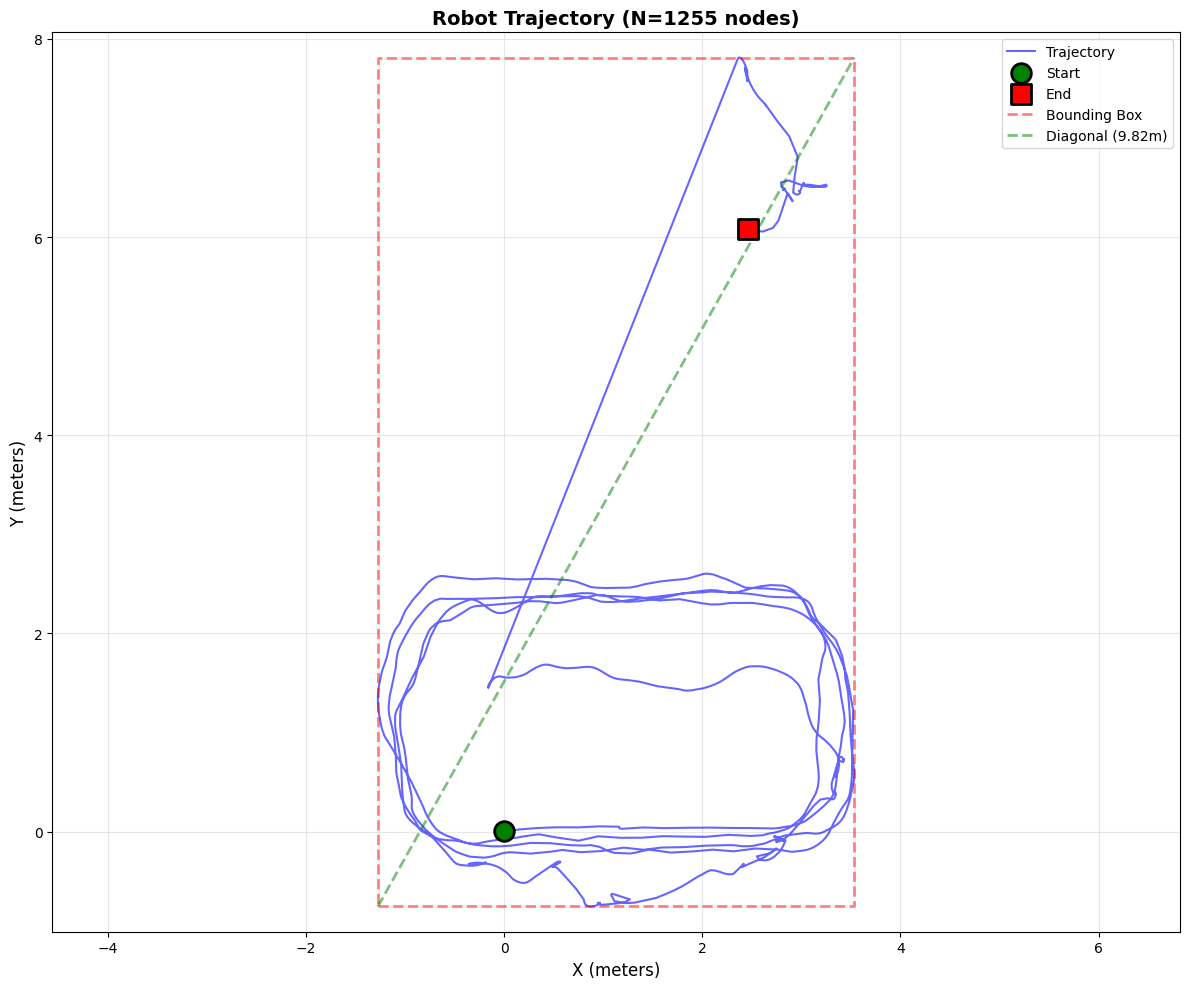

✅ Trajectory visualization complete


In [55]:
print("\n" + "="*70)
print("TRAJECTORY VISUALIZATION")
print("="*70 + "\n")

# Extract coordinates
x_coords = df_trajectory['x_m'].values
y_coords = df_trajectory['y_m'].values

# Calculate bounding box
min_x, max_x = x_coords.min(), x_coords.max()
min_y, max_y = y_coords.min(), y_coords.max()
width = max_x - min_x
height = max_y - min_y
diagonal = np.sqrt(width**2 + height**2)

print("📐 MAP BOUNDING BOX:")
print(f"   X-axis: [{min_x:.3f}, {max_x:.3f}] m")
print(f"   Y-axis: [{min_y:.3f}, {max_y:.3f}] m")
print(f"   Width:  {width:.3f} m")
print(f"   Height: {height:.3f} m")
print(f"   Diagonal (max possible distance): {diagonal:.3f} m\n")

# Create visualization
fig, ax = plt.subplots(figsize=(12, 10))

# Plot trajectory
ax.plot(x_coords, y_coords, 'b-', linewidth=1.5, alpha=0.6, label='Trajectory')
ax.scatter(x_coords[0], y_coords[0], c='green', s=200, marker='o',
           edgecolors='black', linewidths=2, label='Start', zorder=5)
ax.scatter(x_coords[-1], y_coords[-1], c='red', s=200, marker='s',
           edgecolors='black', linewidths=2, label='End', zorder=5)

# Plot bounding box
ax.plot([min_x, max_x, max_x, min_x, min_x],
        [min_y, min_y, max_y, max_y, min_y],
        'r--', linewidth=2, alpha=0.5, label='Bounding Box')

# Plot diagonal
ax.plot([min_x, max_x], [min_y, max_y], 'g--', linewidth=2, alpha=0.5,
        label=f'Diagonal ({diagonal:.2f}m)')

ax.set_xlabel('X (meters)', fontsize=12)
ax.set_ylabel('Y (meters)', fontsize=12)
ax.set_title(f'Robot Trajectory (N={len(df_trajectory)} nodes)', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)
ax.axis('equal')

plt.tight_layout()
plt.show()

print("✅ Trajectory visualization complete")

In [56]:
# Verify timestamp format
print("🔍 TIMESTAMP VERIFICATION\n")

import datetime
import pytz

# First node
sample = df_trajectory.iloc[0]
print(f"Sample node (first):")
print(f"   timestamp_secs: {sample['timestamp_secs']} (type: {type(sample['timestamp_secs']).__name__})")
print(f"   timestamp_nsecs: {sample['timestamp_nsecs']} (type: {type(sample['timestamp_nsecs']).__name__})")

if sample['timestamp_secs'] is not None:
    nsecs = int(sample['timestamp_nsecs']) if sample['timestamp_nsecs'] is not None else 0
    dt_utc = datetime.datetime.fromtimestamp(int(sample['timestamp_secs']), tz=pytz.UTC)
    dt_monterrey = dt_utc.astimezone(pytz.timezone('America/Monterrey'))
    print(f"   Readable UTC: {dt_utc.strftime('%Y-%m-%d %H:%M:%S')}.{nsecs//1000000:03d}")
    print(f"   Readable (America/Monterrey - {dt_monterrey.tzname()}): {dt_monterrey.strftime('%Y-%m-%d %H:%M:%S')}.{nsecs//1000000:03d}")

# Last node
sample_last = df_trajectory.iloc[-1]
print(f"\nSample node (last):")
print(f"   timestamp_secs: {sample_last['timestamp_secs']} (type: {type(sample_last['timestamp_secs']).__name__})")
print(f"   timestamp_nsecs: {sample_last['timestamp_nsecs']} (type: {type(sample_last['timestamp_nsecs']).__name__})")

if sample_last['timestamp_secs'] is not None:
    nsecs_last = int(sample_last['timestamp_nsecs']) if sample_last['timestamp_nsecs'] is not None else 0
    dt_utc_last = datetime.datetime.fromtimestamp(int(sample_last['timestamp_secs']), tz=pytz.UTC)
    dt_monterrey_last = dt_utc_last.astimezone(pytz.timezone('America/Monterrey'))
    print(f"   Readable UTC: {dt_utc_last.strftime('%Y-%m-%d %H:%M:%S')}.{nsecs_last//1000000:03d}")
    print(f"   Readable (America/Monterrey - {dt_monterrey_last.tzname()}): {dt_monterrey_last.strftime('%Y-%m-%d %H:%M:%S')}.{nsecs_last//1000000:03d}")

print(f"\n✅ Timestamps correctly formatted as (seconds, nanoseconds)")


🔍 TIMESTAMP VERIFICATION

Sample node (first):
   timestamp_secs: 1761175578.0 (type: float64)
   timestamp_nsecs: 341865800.0 (type: float64)
   Readable UTC: 2025-10-22 23:26:18.341
   Readable (America/Monterrey - CST): 2025-10-22 17:26:18.341

Sample node (last):
   timestamp_secs: 1761175964.0 (type: float64)
   timestamp_nsecs: 946802100.0 (type: float64)
   Readable UTC: 2025-10-22 23:32:44.946
   Readable (America/Monterrey - CST): 2025-10-22 17:32:44.946

✅ Timestamps correctly formatted as (seconds, nanoseconds)


In [57]:
# Trajectory profiling - consecutive nodes
print("\n📊 TRAJECTORY PROFILING (CONSECUTIVE NODES)\n")


# Calculate distances and time differences between consecutive nodes
consecutive_distances = []
consecutive_times = []

for i in range(len(df_trajectory) - 1):
    node1 = df_trajectory.iloc[i]
    node2 = df_trajectory.iloc[i + 1]

    # Distance
    dist = np.sqrt((node2['x_m'] - node1['x_m'])**2 + (node2['y_m'] - node1['y_m'])**2)
    consecutive_distances.append(dist)

    # Time difference
    if node1['timestamp_secs'] is not None and node2['timestamp_secs'] is not None:
        time_diff_ns = (
            (node2['timestamp_secs'] - node1['timestamp_secs']) * 1_000_000_000 +
            (node2['timestamp_nsecs'] - node1['timestamp_nsecs'])
        )
        time_diff_secs = time_diff_ns / 1_000_000_000
        consecutive_times.append(time_diff_secs)

consecutive_distances = np.array(consecutive_distances)
consecutive_times = np.array(consecutive_times)


# Statistics table
print("\n📈 DESCRIPTIVE STATISTICS\n")
print("Distance Between Consecutive Nodes (meters):")
print(f"   Count:  {len(consecutive_distances)}")
print(f"   Min:    {consecutive_distances.min():.6f} m")
print(f"   Max:    {consecutive_distances.max():.6f} m")
print(f"   Mean:   {consecutive_distances.mean():.6f} m")
print(f"   Median: {np.median(consecutive_distances):.6f} m")
print(f"   Std:    {consecutive_distances.std():.6f} m")

print("\nTime Between Consecutive Nodes (seconds):")
print(f"   Count:  {len(consecutive_times)}")
print(f"   Min:    {consecutive_times.min():.6f} s")
print(f"   Max:    {consecutive_times.max():.6f} s")
print(f"   Mean:   {consecutive_times.mean():.6f} s")
print(f"   Median: {np.median(consecutive_times):.6f} s")
print(f"   Std:    {consecutive_times.std():.6f} s")

print("\nTrajectory Velocity Profile:")
velocities = consecutive_distances / consecutive_times
print(f"   Mean velocity:   {velocities.mean():.6f} m/s")
print(f"   Median velocity: {np.median(velocities):.6f} m/s")
print(f"   Max velocity:    {velocities.max():.6f} m/s")


📊 TRAJECTORY PROFILING (CONSECUTIVE NODES)


📈 DESCRIPTIVE STATISTICS

Distance Between Consecutive Nodes (meters):
   Count:  1254
   Min:    0.000845 m
   Max:    6.828017 m
   Mean:   0.058617 m
   Median: 0.034281 m
   Std:    0.199323 m

Time Between Consecutive Nodes (seconds):
   Count:  1254
   Min:    0.114630 s
   Max:    48.649355 s
   Mean:   0.308297 s
   Median: 0.135182 s
   Std:    1.420958 s

Trajectory Velocity Profile:
   Mean velocity:   0.214999 m/s
   Median velocity: 0.239200 m/s
   Max velocity:    0.460624 m/s


---
## 3.6 NODE PAIRING
---

In [58]:
print("\n🔗 CREATING ALL NODE PAIRS...\n")
print("⚠️  Creating ~786,885 pairs. Please wait...\n")

node_pairs_data = []
n_nodes = len(df_trajectory)

for i in range(n_nodes):
    if i % 100 == 0:
        print(f"   Processing node {i}/{n_nodes}...")

    node1 = df_trajectory.iloc[i]

    for j in range(i + 1, n_nodes):
        node2 = df_trajectory.iloc[j]

        distance = np.sqrt((node2['x_m'] - node1['x_m'])**2 + (node2['y_m'] - node1['y_m'])**2)

        time_diff_secs = 0.0
        if node1['timestamp_secs'] is not None and node2['timestamp_secs'] is not None:
            time_diff_ns = (
                (node2['timestamp_secs'] - node1['timestamp_secs']) * 1_000_000_000 +
                (node2['timestamp_nsecs'] - node1['timestamp_nsecs'])
            )
            time_diff_secs = round(time_diff_ns / 1_000_000_000, 5)

        node_pairs_data.append({
            'node1_id': node1['node_id'],
            'node2_id': node2['node_id'],
            'distance_between_nodes_m': distance,
            'time_diff_secs': time_diff_secs,
            'loop_closure': 0  # Initialize to 0, will be marked during loop closure extraction
        })

df_all_pairs = pd.DataFrame(node_pairs_data)

print(f"\n✅ Created: {len(df_all_pairs):,} pairs\n")
print(f"📊 Statistics:")
print(f"   Distance - Min: {df_all_pairs['distance_between_nodes_m'].min():.6f} m")
print(f"   Distance - Max: {df_all_pairs['distance_between_nodes_m'].max():.6f} m")
print(f"   Distance - Mean: {df_all_pairs['distance_between_nodes_m'].mean():.6f} m")
print(f"   Time - Min: {df_all_pairs['time_diff_secs'].min():.5f} s")
print(f"   Time - Max: {df_all_pairs['time_diff_secs'].max():.5f} s")
print(f"   Loop closures: 0 (will be marked after extraction)")


🔗 CREATING ALL NODE PAIRS...

⚠️  Creating ~786,885 pairs. Please wait...

   Processing node 0/1255...
   Processing node 100/1255...
   Processing node 200/1255...
   Processing node 300/1255...
   Processing node 400/1255...
   Processing node 500/1255...
   Processing node 600/1255...
   Processing node 700/1255...
   Processing node 800/1255...
   Processing node 900/1255...
   Processing node 1000/1255...
   Processing node 1100/1255...
   Processing node 1200/1255...

✅ Created: 786,885 pairs

📊 Statistics:
   Distance - Min: 0.000406 m
   Distance - Max: 8.700595 m
   Distance - Mean: 3.006543 m
   Time - Min: 0.11463 s
   Time - Max: 386.60494 s
   Loop closures: 0 (will be marked after extraction)


### 3.6.1 Distance Coherency Check

In [59]:
print("\n" + "="*70)
print("DISTANCE COHERENCY CHECK")
print("="*70 + "\n")

# Calculate map diagonal (maximum possible distance)
x_coords = df_trajectory['x_m'].values
y_coords = df_trajectory['y_m'].values
min_x, max_x = x_coords.min(), x_coords.max()
min_y, max_y = y_coords.min(), y_coords.max()
width = max_x - min_x
height = max_y - min_y
max_possible_distance = np.sqrt(width**2 + height**2)

print(f"📊 VALIDATION:")
print(f"   Map diagonal (max theoretical distance): {max_possible_distance:.3f} m")
print(f"   Max computed distance in pairs: {df_all_pairs['distance_between_nodes_m'].max():.3f} m\n")

# Check for invalid distances
invalid_distances = df_all_pairs[df_all_pairs['distance_between_nodes_m'] > max_possible_distance]

if len(invalid_distances) > 0:
    print(f"❌ COHERENCY CHECK FAILED!")
    print(f"   Found {len(invalid_distances)} pairs with distances exceeding map diagonal")
    print(f"\n🔍 Invalid pairs sample:")
    print(invalid_distances[['node1_id', 'node2_id', 'distance_between_nodes_m']].head(10))
    raise ValueError(f"Distance coherency check failed: {len(invalid_distances)} invalid pairs found")
else:
    print(f"✅ COHERENCY CHECK PASSED")
    print(f"   All {len(df_all_pairs):,} pairwise distances are within valid range")
    print(f"   Max distance / Diagonal ratio: {df_all_pairs['distance_between_nodes_m'].max() / max_possible_distance:.4f}\n")

# Additional statistics
print(f"📈 DISTANCE DISTRIBUTION:")
quantiles = df_all_pairs['distance_between_nodes_m'].quantile([0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
print(f"   25th percentile: {quantiles[0.25]:.3f} m")
print(f"   50th percentile (median): {quantiles[0.5]:.3f} m")
print(f"   75th percentile: {quantiles[0.75]:.3f} m")
print(f"   90th percentile: {quantiles[0.9]:.3f} m")
print(f"   95th percentile: {quantiles[0.95]:.3f} m")
print(f"   99th percentile: {quantiles[0.99]:.3f} m")

print("\n" + "="*70)
print("✅ DISTANCE COHERENCY VALIDATION COMPLETE")
print("="*70)



DISTANCE COHERENCY CHECK

📊 VALIDATION:
   Map diagonal (max theoretical distance): 9.825 m
   Max computed distance in pairs: 8.701 m

✅ COHERENCY CHECK PASSED
   All 786,885 pairwise distances are within valid range
   Max distance / Diagonal ratio: 0.8856

📈 DISTANCE DISTRIBUTION:
   25th percentile: 1.619 m
   50th percentile (median): 2.794 m
   75th percentile: 4.107 m
   90th percentile: 5.788 m
   95th percentile: 6.842 m
   99th percentile: 7.786 m

✅ DISTANCE COHERENCY VALIDATION COMPLETE


---
## 3.7 LOOP CLOSURE EXTRACTION AND ANALYSIS
---

In [60]:
print("🔗 EXTRACTING LOOP CLOSURES (ORIGINAL ALGORITHM)...\n")

# EXACT ORIGINAL EXTRACTION CODE
with open(PBSTREAM_FILE, 'rb') as f:
    data = f.read()

pos = 8
trajectory = []  # (x, y, timestamp)
loop_closure_pairs = []
total_constraints = 0
submap_to_nodes = {}
loop_closure_count = 0

msg_count = 0
pg_count = 0

while pos < len(data):
    try:
        if pos + 8 > len(data): break
        msg_len = struct.unpack('<Q', data[pos:pos+8])[0]
        pos += 8
        if msg_len == 0 or msg_len > len(data) or pos + msg_len > len(data): break
        compressed = data[pos:pos + msg_len]
        pos += msg_len
        msg_count += 1

        try:
            msg_data = zlib.decompress(compressed, 16 + zlib.MAX_WBITS)
        except:
            continue

        if len(msg_data) < 2: continue
        tag, _ = _DecodeVarint32(msg_data, 0)
        field_number = tag >> 3

        if field_number == 4:  # Node
            node_pos = 0
            tag, node_pos = _DecodeVarint32(msg_data, node_pos)
            node_len, node_pos = _DecodeVarint32(msg_data, node_pos)
            node_data = msg_data[node_pos:node_pos + node_len]
            timestamp = extract_timestamp(node_data)

            inner_pos = 0
            while inner_pos < len(node_data):
                tag, inner_pos = _DecodeVarint32(node_data, inner_pos)
                fn = tag >> 3
                wt = tag & 0x7
                if fn == 5 and wt == 2:
                    f5_len, inner_pos = _DecodeVarint32(node_data, inner_pos)
                    f5_data = node_data[inner_pos:inner_pos + f5_len]
                    x, y = extract_xy(f5_data)
                    if x is not None and y is not None:
                        trajectory.append((x, y, timestamp))
                    break
                elif wt == 0:
                    _, inner_pos = _DecodeVarint32(node_data, inner_pos)
                elif wt == 1:
                    inner_pos += 8
                elif wt == 2:
                    l, inner_pos = _DecodeVarint32(node_data, inner_pos)
                    inner_pos += l
                elif wt == 5:
                    inner_pos += 4

        elif field_number == 1:  # PoseGraph
            pg_count += 1
            if pg_count == 2:  # CRITICAL: Use second POSE_GRAPH message
                pg_pos = 0
                tag, pg_pos = _DecodeVarint32(msg_data, pg_pos)
                pg_len, pg_pos = _DecodeVarint32(msg_data, pg_pos)
                pg_data = msg_data[pg_pos:pg_pos + pg_len]

                p = 0
                while p < len(pg_data):
                    try:
                        tag, p = _DecodeVarint32(pg_data, p)
                        fn = tag >> 3
                        wt = tag & 0x7

                        if fn == 2 and wt == 2:  # CRITICAL: Field 2 = Constraint
                            total_constraints += 1
                            cl, p = _DecodeVarint32(pg_data, p)
                            cd = pg_data[p:p+cl]

                            cp = 0
                            ctag = 0
                            node_idx = None
                            submap_idx = None

                            while cp < len(cd):
                                try:
                                    ct, cp = _DecodeVarint32(cd, cp)
                                    cf = ct >> 3
                                    cw = ct & 0x7

                                    if cf == 1 and cw == 2:  # Submap ID
                                        sid_len, cp = _DecodeVarint32(cd, cp)
                                        sid_data = cd[cp:cp+sid_len]
                                        sp = 0
                                        while sp < len(sid_data):
                                            st, sp = _DecodeVarint32(sid_data, sp)
                                            sf = st >> 3
                                            sw = st & 0x7
                                            if sf == 2 and sw == 0:
                                                submap_idx, sp = _DecodeVarint32(sid_data, sp)
                                                break
                                            elif sw == 0:
                                                _, sp = _DecodeVarint32(sid_data, sp)
                                            elif sw == 2:
                                                sl, sp = _DecodeVarint32(sid_data, sp)
                                                sp += sl
                                            else:
                                                break
                                        cp += sid_len

                                    elif cf == 2 and cw == 2:  # Node ID
                                        nid_len, cp = _DecodeVarint32(cd, cp)
                                        nid_data = cd[cp:cp+nid_len]
                                        nid_pos = 0
                                        while nid_pos < len(nid_data):
                                            nt, nid_pos = _DecodeVarint32(nid_data, nid_pos)
                                            nf = nt >> 3
                                            nw = nt & 0x7
                                            if nf == 2 and nw == 0:
                                                node_idx, nid_pos = _DecodeVarint32(nid_data, nid_pos)
                                                break
                                            elif nw == 0:
                                                _, nid_pos = _DecodeVarint32(nid_data, nid_pos)
                                            elif nw == 2:
                                                nl, nid_pos = _DecodeVarint32(nid_data, nid_pos)
                                                nid_pos += nl
                                            else:
                                                break
                                        cp += nid_len

                                    elif cf == 5 and cw == 0:  # Tag field
                                        ctag, cp = _DecodeVarint32(cd, cp)

                                    elif cw == 0:
                                        _, cp = _DecodeVarint32(cd, cp)
                                    elif cw == 1:
                                        cp += 8
                                    elif cw == 2:
                                        cll, cp = _DecodeVarint32(cd, cp)
                                        cp += cll
                                    elif cw == 5:
                                        cp += 4
                                    else:
                                        break
                                except:
                                    break

                            if ctag == 0 and node_idx is not None and submap_idx is not None:
                                # INTRA_SUBMAP
                                if submap_idx not in submap_to_nodes:
                                    submap_to_nodes[submap_idx] = []
                                submap_to_nodes[submap_idx].append(node_idx)

                            elif ctag == 1 and node_idx is not None and submap_idx is not None:
                                # INTER_SUBMAP: Loop closure
                                loop_closure_count += 1
                                loop_closure_pairs.append((submap_idx, node_idx))

                            p += cl
                        elif wt == 0:
                            _, p = _DecodeVarint32(pg_data, p)
                        elif wt == 1:
                            p += 8
                        elif wt == 2:
                            ll, p = _DecodeVarint32(pg_data, p)
                            p += ll
                        elif wt == 5:
                            p += 4
                        else:
                            break
                    except:
                        break
    except:
        break

# Process loop closures
processed_loop_pairs = []
invalid_count = 0

for submap_idx, node_idx in loop_closure_pairs:
    if node_idx >= len(trajectory):
        invalid_count += 1
        continue

    if submap_idx in submap_to_nodes and len(submap_to_nodes[submap_idx]) > 0:
        nodes_in_submap = [n for n in submap_to_nodes[submap_idx] if n < len(trajectory)]

        if len(nodes_in_submap) > 0:
            target_x, target_y, _ = trajectory[node_idx]
            min_dist = float('inf')
            best_ref_idx = None

            for ref_idx in nodes_in_submap:
                if ref_idx < node_idx:
                    dx = trajectory[ref_idx][0] - target_x
                    dy = trajectory[ref_idx][1] - target_y
                    dist = (dx**2 + dy**2)**0.5
                    if dist < min_dist:
                        min_dist = dist
                        best_ref_idx = ref_idx

            if best_ref_idx is not None:
                processed_loop_pairs.append((best_ref_idx, node_idx))

loop_closure_pairs = processed_loop_pairs

print(f"✅ Loop closures extracted: {len(loop_closure_pairs)} pairs")
print(f"   Total INTER_SUBMAP constraints: {loop_closure_count}")
print(f"   Submaps tracked: {len(submap_to_nodes)}")
print(f"   Trajectory nodes: {len(trajectory)}")

🔗 EXTRACTING LOOP CLOSURES (ORIGINAL ALGORITHM)...

✅ Loop closures extracted: 406 pairs
   Total INTER_SUBMAP constraints: 805
   Submaps tracked: 35
   Trajectory nodes: 1255


In [61]:
# Mark loop closures in df_all_pairs
print("\n🔗 MARKING LOOP CLOSURES IN NODE PAIRS...\n")

marked_count = 0

for ref_idx, node_idx in loop_closure_pairs:
    if ref_idx < len(df_trajectory) and node_idx < len(df_trajectory):
        # Find the pair in df_all_pairs and mark it
        mask = (df_all_pairs['node1_id'] == ref_idx) & (df_all_pairs['node2_id'] == node_idx)
        if mask.any():
            df_all_pairs.loc[mask, 'loop_closure'] = 1
            marked_count += 1

print(f"✅ Marked: {marked_count} loop closure pairs in df_all_pairs")
print(f"   Total pairs: {len(df_all_pairs):,}")
print(f"   Loop closures: {df_all_pairs['loop_closure'].sum()} ({100*df_all_pairs['loop_closure'].sum()/len(df_all_pairs):.3f}%)")

# Create filtered view for display
df_loop_closures = df_all_pairs[df_all_pairs['loop_closure'] == 1][['node1_id', 'node2_id', 'distance_between_nodes_m', 'time_diff_secs']].copy()

print(f"\n📋 First 50 loop closure pairs:")
display(df_loop_closures.head(50))
print(f"\n📋 Last 50 loop closure pairs:")
display(df_loop_closures.tail(50))


🔗 MARKING LOOP CLOSURES IN NODE PAIRS...

✅ Marked: 406 loop closure pairs in df_all_pairs
   Total pairs: 786,885
   Loop closures: 406 (0.052%)

📋 First 50 loop closure pairs:


,node1_id,node2_id,distance_between_nodes_m,time_diff_secs
45429,36.0,952.0,0.025163,237.91770
45434,36.0,957.0,0.013182,244.09490
50363,40.0,1024.0,0.078557,262.64145
51537,41.0,985.0,0.067171,248.17507
51547,41.0,995.0,0.063022,249.76031
51581,41.0,1029.0,0.029172,262.91324
60649,49.0,429.0,0.094426,98.35462
63671,51.0,1044.0,0.360064,263.16983
65657,53.0,627.0,0.078664,146.90694
67864,55.0,435.0,0.094407,98.50267



📋 Last 50 loop closure pairs:


,node1_id,node2_id,distance_between_nodes_m,time_diff_secs
498333,494.0,1123.0,0.648006,162.22162
500166,497.0,682.0,0.021054,48.61333
506952,506.0,700.0,0.079983,48.90823
515861,518.0,711.0,0.084424,48.42704
516297,518.0,1147.0,0.742233,158.84519
521716,526.0,714.0,0.008323,48.83842
526070,532.0,721.0,0.055232,48.95663
528233,535.0,724.0,0.048300,49.09719
528952,536.0,725.0,0.053394,49.10431
531103,539.0,728.0,0.098109,48.72318


---

# SECTION 4: FEATURES LOADING & ANALYSIS

HDF5 features validation.

---



### 4.1 FILE LOADING AND VALIDATION




In [62]:
print("Loading extracted features from HDF5...")

with h5py.File(FEATURES_FILE, 'r') as f:
    # Load camera features and split timestamps
    camera_features = f['camera/features'][:]
    camera_timestamps_sec = f['camera/timestamps_sec'][:].astype(np.int64)
    camera_timestamps_nsec = f['camera/timestamps_nsec'][:].astype(np.int32)
    camera_filenames = [fn.decode('utf-8') if isinstance(fn, bytes) else fn
                       for fn in f['camera/filenames'][:]]

    # Load LiDAR features and split timestamps
    lidar_features = f['lidar/features'][:]
    lidar_timestamps_sec = f['lidar/timestamps_sec'][:].astype(np.int64)
    lidar_timestamps_nsec = f['lidar/timestamps_nsec'][:].astype(np.int32)
    lidar_filenames = [fn.decode('utf-8') if isinstance(fn, bytes) else fn
                      for fn in f['lidar/filenames'][:]]

# Create float64 timestamps for convenience (temporal operations)
# Note: float64 loses ~250ns precision, but this is negligible vs ±0.7s alignment threshold
camera_timestamps = camera_timestamps_sec + camera_timestamps_nsec * 1e-9
lidar_timestamps = lidar_timestamps_sec + lidar_timestamps_nsec * 1e-9

print(f"\n✅ Features loaded successfully:")
print(f"   Camera: {len(camera_features)} frames, {camera_features.shape[1]}D features")
print(f"   LiDAR: {len(lidar_features)} scans, {lidar_features.shape[1]}D features")
print(f"   Time range: {min(min(camera_timestamps), min(lidar_timestamps)):.2f}s to {max(max(camera_timestamps), max(lidar_timestamps)):.2f}s")

# Verify L2 normalization
camera_norms = np.linalg.norm(camera_features, axis=1)
lidar_norms = np.linalg.norm(lidar_features, axis=1)
print(f"\n Feature normalization check:")
print(f"   Camera L2 norms: mean={camera_norms.mean():.4f}, std={camera_norms.std():.4f}")
print(f"   LiDAR L2 norms: mean={lidar_norms.mean():.4f}, std={lidar_norms.std():.4f}")

if not (np.allclose(camera_norms, 1.0, atol=1e-5) and np.allclose(lidar_norms, 1.0, atol=1e-5)):
    print("   ⚠️ WARNING: Features are not properly L2 normalized!")
else:
    print("   ✅ Features are properly L2 normalized")

Loading extracted features from HDF5...

✅ Features loaded successfully:
   Camera: 7193 frames, 1280D features
   LiDAR: 2973 scans, 256D features
   Time range: 1761175571.69s to 1761175967.53s

 Feature normalization check:
   Camera L2 norms: mean=1.0000, std=0.0000
   LiDAR L2 norms: mean=1.0000, std=0.0000
   ✅ Features are properly L2 normalized


### 4.2 H5 DATA ANALYSIS

**Purpose:** Deep analysis and validation of extracted features before proceeding with dataset generation.

In [63]:
print("\n" + "=" * 80)
print("COMPREHENSIVE HDF5 DATA ANALYSIS")
print("=" * 80)

# =======================================================================
#  Basic Statistics
# =======================================================================
print("\n BASIC FEATURE STATISTICS")
print("-" * 80)

print(f"\n Camera Features:")
print(f"   Count: {len(camera_features)} frames")
print(f"   Dimension: {camera_features.shape[1]}D")
print(f"   Data type: {camera_features.dtype}")
print(f"   Memory: {camera_features.nbytes / 1024 / 1024:.2f} MB")
print(f"   Value range: [{camera_features.min():.4f}, {camera_features.max():.4f}]")
print(f"   Mean: {camera_features.mean():.4f}, Std: {camera_features.std():.4f}")

print(f"\n LiDAR Features:")
print(f"   Count: {len(lidar_features)} scans")
print(f"   Dimension: {lidar_features.shape[1]}D")
print(f"   Data type: {lidar_features.dtype}")
print(f"   Memory: {lidar_features.nbytes / 1024 / 1024:.2f} MB")
print(f"   Value range: [{lidar_features.min():.4f}, {lidar_features.max():.4f}]")
print(f"   Mean: {lidar_features.mean():.4f}, Std: {lidar_features.std():.4f}")

# =======================================================================
#  Timestamp Analysis
# =======================================================================
print(f"\n\n⏱️  TIMESTAMP ANALYSIS")
print("-" * 80)

print(f"\n Camera Timestamps:")
cam_duration = camera_timestamps[-1] - camera_timestamps[0]
cam_intervals = np.diff(camera_timestamps)

cam_start_dt_utc = datetime.datetime.fromtimestamp(camera_timestamps[0], tz=pytz.UTC)
cam_end_dt_utc = datetime.datetime.fromtimestamp(camera_timestamps[-1], tz=pytz.UTC)
cam_start_dt_mty = cam_start_dt_utc.astimezone(pytz.timezone('America/Monterrey'))
cam_end_dt_mty = cam_end_dt_utc.astimezone(pytz.timezone('America/Monterrey'))

print(f"   Start timestamp: {camera_timestamps[0]:.3f}s")
print(f"   End timestamp: {camera_timestamps[-1]:.3f}s")
print(f"   Start readable UTC: {cam_start_dt_utc.strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]}")
print(f"   End readable UTC: {cam_end_dt_utc.strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]}")
print(f"   Start readable (America/Monterrey - {cam_start_dt_mty.tzname()}): {cam_start_dt_mty.strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]}")
print(f"   End readable (America/Monterrey - {cam_end_dt_mty.tzname()}): {cam_end_dt_mty.strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]}")
print(f"   Duration: {cam_duration:.2f}s ({cam_duration/60:.2f} minutes)")
print(f"   Intervals - Mean: {cam_intervals.mean():.3f}s, Std: {cam_intervals.std():.3f}s")
print(f"   Intervals - Min: {cam_intervals.min():.3f}s, Max: {cam_intervals.max():.3f}s")
print(f"   Effective rate: {len(camera_features) / cam_duration:.2f} Hz")

print(f"\n LiDAR Timestamps:")
lid_duration = lidar_timestamps[-1] - lidar_timestamps[0]
lid_intervals = np.diff(lidar_timestamps)

lid_start_dt_utc = datetime.datetime.fromtimestamp(lidar_timestamps[0], tz=pytz.UTC)
lid_end_dt_utc = datetime.datetime.fromtimestamp(lidar_timestamps[-1], tz=pytz.UTC)
lid_start_dt_mty = lid_start_dt_utc.astimezone(pytz.timezone('America/Monterrey'))
lid_end_dt_mty = lid_end_dt_utc.astimezone(pytz.timezone('America/Monterrey'))

print(f"   Start timestamp: {lidar_timestamps[0]:.3f}s")
print(f"   End timestamp: {lidar_timestamps[-1]:.3f}s")
print(f"   Start readable UTC: {lid_start_dt_utc.strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]}")
print(f"   End readable UTC: {lid_end_dt_utc.strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]}")
print(f"   Start readable (America/Monterrey - {lid_start_dt_mty.tzname()}): {lid_start_dt_mty.strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]}")
print(f"   End readable (America/Monterrey - {lid_end_dt_mty.tzname()}): {lid_end_dt_mty.strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]}")
print(f"   Duration: {lid_duration:.2f}s ({lid_duration/60:.2f} minutes)")
print(f"   Intervals - Mean: {lid_intervals.mean():.3f}s, Std: {lid_intervals.std():.3f}s")
print(f"   Intervals - Min: {lid_intervals.min():.3f}s, Max: {lid_intervals.max():.3f}s")
print(f"   Effective rate: {len(lidar_features) / lid_duration:.2f} Hz")

# Temporal overlap
cam_start, cam_end = camera_timestamps[0], camera_timestamps[-1]
lid_start, lid_end = lidar_timestamps[0], lidar_timestamps[-1]
overlap_start = max(cam_start, lid_start)
overlap_end = min(cam_end, lid_end)
overlap_duration = max(0, overlap_end - overlap_start)

print(f"\n Cross-Modal Temporal Analysis:")
print(f"   Camera start timestamp: {cam_start:.3f}s")
print(f"   Camera end timestamp: {cam_end:.3f}s")
print(f"   Camera start readable UTC: {cam_start_dt_utc.strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]}")
print(f"   Camera end readable UTC: {cam_end_dt_utc.strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]}")
print(f"   Camera start readable (America/Monterrey - {cam_start_dt_mty.tzname()}): {cam_start_dt_mty.strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]}")
print(f"   Camera end readable (America/Monterrey - {cam_end_dt_mty.tzname()}): {cam_end_dt_mty.strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]}")
print(f"\n   LiDAR start timestamp: {lid_start:.3f}s")
print(f"   LiDAR end timestamp: {lid_end:.3f}s")
print(f"   LiDAR start readable UTC: {lid_start_dt_utc.strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]}")
print(f"   LiDAR end readable UTC: {lid_end_dt_utc.strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]}")
print(f"   LiDAR start readable (America/Monterrey - {lid_start_dt_mty.tzname()}): {lid_start_dt_mty.strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]}")
print(f"   LiDAR end readable (America/Monterrey - {lid_end_dt_mty.tzname()}): {lid_end_dt_mty.strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]}")
print(f"\n   Temporal overlap: {overlap_duration:.2f}s ({overlap_duration/60:.2f} minutes)")
print(f"   Overlap ratio: {overlap_duration/max(cam_duration, lid_duration):.1%}")

if overlap_duration < 10:
    print(f"   ⚠️  WARNING: Very short temporal overlap (<10s)!")
elif overlap_duration < 30:
    print(f"   ⚠️  WARNING: Short temporal overlap (<30s), dataset may be limited")
else:
    print(f"   ✅ Good temporal overlap for dataset generation")

# Time offset detection
time_offset = abs(cam_start - lid_start)
if time_offset > 5.0:
    print(f"   ⚠️  WARNING: Large time offset between sensors: {time_offset:.2f}s")
    print(f"       This may indicate sensor desynchronization")

# Gap detection
print(f"\n Temporal Gap Detection:")
cam_gaps = np.where(cam_intervals > 10.0)[0]
lid_gaps = np.where(lid_intervals > 10.0)[0]

if len(cam_gaps) > 0:
    print(f"   Camera: Found {len(cam_gaps)} gaps >10s")
    for gap_idx in cam_gaps[:3]:  # Show first 3
        print(f"     • Gap at frame {gap_idx}: {cam_intervals[gap_idx]:.2f}s")
    if len(cam_gaps) > 3:
        print(f"     • ... and {len(cam_gaps)-3} more gaps")
else:
    print(f"   Camera: No significant gaps detected")

if len(lid_gaps) > 0:
    print(f"   LiDAR: Found {len(lid_gaps)} gaps >10s")
    for gap_idx in lid_gaps[:3]:
        print(f"     • Gap at scan {gap_idx}: {lid_intervals[gap_idx]:.2f}s")
    if len(lid_gaps) > 3:
        print(f"     • ... and {len(lid_gaps)-3} more gaps")
else:
    print(f"   LiDAR: No significant gaps detected")

# =======================================================================
#  Feature Quality Analysis
# =======================================================================
print(f"\n\n FEATURE QUALITY ANALYSIS")
print("-" * 80)

# Check for NaN/Inf
cam_nan = np.isnan(camera_features).sum()
cam_inf = np.isinf(camera_features).sum()
lid_nan = np.isnan(lidar_features).sum()
lid_inf = np.isinf(lidar_features).sum()

print(f"\n Camera Feature Quality:")
print(f"   NaN values: {cam_nan} ({cam_nan/camera_features.size:.2%})")
print(f"   Inf values: {cam_inf} ({cam_inf/camera_features.size:.2%})")
if cam_nan > 0 or cam_inf > 0:
    print(f"   ❌ CRITICAL: Invalid values detected in camera features!")
else:
    print(f"   ✅ No invalid values detected")

# Check for zero features
cam_zero_frames = np.sum(np.all(camera_features == 0, axis=1))
print(f"   All-zero frames: {cam_zero_frames} ({cam_zero_frames/len(camera_features):.1%})")
if cam_zero_frames > 0:
    print(f"   ⚠️  WARNING: {cam_zero_frames} frames have all-zero features")

print(f"\n LiDAR Feature Quality:")
print(f"   NaN values: {lid_nan} ({lid_nan/lidar_features.size:.2%})")
print(f"   Inf values: {lid_inf} ({lid_inf/lidar_features.size:.2%})")
if lid_nan > 0 or lid_inf > 0:
    print(f"   ❌ CRITICAL: Invalid values detected in LiDAR features!")
else:
    print(f"   ✅ No invalid values detected")

lid_zero_scans = np.sum(np.all(lidar_features == 0, axis=1))
print(f"   All-zero scans: {lid_zero_scans} ({lid_zero_scans/len(lidar_features):.1%})")
if lid_zero_scans > 0:
    print(f"   ⚠️  WARNING: {lid_zero_scans} scans have all-zero features")

# Normalization verification (already done, but detailed here)
print(f"\n✅ L2 Normalization Verification:")
cam_norm_errors = np.abs(camera_norms - 1.0)
lid_norm_errors = np.abs(lidar_norms - 1.0)
print(f"   Camera - Max error: {cam_norm_errors.max():.2e}, Mean error: {cam_norm_errors.mean():.2e}")
print(f"   LiDAR - Max error: {lid_norm_errors.max():.2e}, Mean error: {lid_norm_errors.mean():.2e}")

if cam_norm_errors.max() > 1e-4 or lid_norm_errors.max() > 1e-4:
    print(f"   ⚠️  WARNING: Some features deviate significantly from unit norm")
else:
    print(f"   ✅ All features properly normalized (error < 1e-4)")

# =======================================================================
#  Feature Distribution Analysis
# =======================================================================
print(f"\n\n FEATURE DISTRIBUTION ANALYSIS")
print("-" * 80)

# Sparsity analysis
cam_sparsity = (camera_features == 0).sum() / camera_features.size
lid_sparsity = (lidar_features == 0).sum() / lidar_features.size

print(f"\n Camera Feature Distribution:")
print(f"   Sparsity: {cam_sparsity:.1%} (fraction of zero values)")
print(f"   Non-zero values per frame - Mean: {(camera_features != 0).sum(axis=1).mean():.0f}, Std: {(camera_features != 0).sum(axis=1).std():.0f}")

# Check for duplicate frames
cam_unique = len(np.unique(camera_features, axis=0))
cam_duplicates = len(camera_features) - cam_unique
print(f"   Unique frames: {cam_unique}/{len(camera_features)}")
if cam_duplicates > 0:
    print(f"   ⚠️  WARNING: {cam_duplicates} duplicate frames detected ({cam_duplicates/len(camera_features):.1%})")
else:
    print(f"   ✅ No duplicate frames detected")

print(f"\n LiDAR Feature Distribution:")
print(f"   Sparsity: {lid_sparsity:.1%} (fraction of zero values)")
print(f"   Non-zero values per scan - Mean: {(lidar_features != 0).sum(axis=1).mean():.0f}, Std: {(lidar_features != 0).sum(axis=1).std():.0f}")

lid_unique = len(np.unique(lidar_features, axis=0))
lid_duplicates = len(lidar_features) - lid_unique
print(f"   Unique scans: {lid_unique}/{len(lidar_features)}")
if lid_duplicates > 0:
    print(f"   ⚠️  WARNING: {lid_duplicates} duplicate scans detected ({lid_duplicates/len(lidar_features):.1%})")
else:
    print(f"   ✅ No duplicate scans detected")

# =======================================================================
#  Timestamp Precision Analysis
# =======================================================================
print(f"\n\n TIMESTAMP PRECISION ANALYSIS")
print("-" * 80)

print(f"\n Split Timestamp Format:")
print(f"   Storage format: timestamps_sec (int64) + timestamps_nsec (int32)")
print(f"   Precision: Full nanosecond precision maintained")
print(f"   Camera timestamps_sec range: [{camera_timestamps_sec.min()}, {camera_timestamps_sec.max()}]")
print(f"   Camera timestamps_nsec range: [{camera_timestamps_nsec.min()}, {camera_timestamps_nsec.max()}]")
print(f"   LiDAR timestamps_sec range: [{lidar_timestamps_sec.min()}, {lidar_timestamps_sec.max()}]")
print(f"   LiDAR timestamps_nsec range: [{lidar_timestamps_nsec.min()}, {lidar_timestamps_nsec.max()}]")

# Reconstruct and compare
cam_recon = camera_timestamps_sec + camera_timestamps_nsec * 1e-9
lid_recon = lidar_timestamps_sec + lidar_timestamps_nsec * 1e-9
cam_precision_loss = np.abs(cam_recon - camera_timestamps).max()
lid_precision_loss = np.abs(lid_recon - lidar_timestamps).max()

print(f"\n Float64 Conversion Analysis:")
print(f"   Camera max precision loss: {cam_precision_loss*1e9:.2f} ns")
print(f"   LiDAR max precision loss: {lid_precision_loss*1e9:.2f} ns")
print(f"   Temporal alignment threshold: {MAX_TIME_OFFSET*1e9:.0f} ns ({MAX_TIME_OFFSET}s)")
print(f"   Precision loss vs threshold: {cam_precision_loss/MAX_TIME_OFFSET:.2e}x")

if cam_precision_loss < 1e-6 and lid_precision_loss < 1e-6:
    print(f"   ✅ Precision loss negligible (<1 microsecond)")
    print(f"   ✅ Float64 safe for all temporal operations in this notebook")
else:
    print(f"   ⚠️  WARNING: Precision loss > 1 microsecond detected")

# =======================================================================
#  Cross-Modal Synchronization Preview
# =======================================================================
print(f"\n\n CROSS-MODAL SYNCHRONIZATION PREVIEW")
print("-" * 80)

print(f"\nEstimating potential aligned pairs (using ±{MAX_TIME_OFFSET}s threshold):")

# Count how many camera frames can be aligned
aligned_count = 0
for cam_t in camera_timestamps:
    # Find closest LiDAR timestamp
    time_diffs = np.abs(lidar_timestamps - cam_t)
    min_diff = time_diffs.min()
    if min_diff < MAX_TIME_OFFSET:
        aligned_count += 1

alignment_rate = aligned_count / len(camera_timestamps)
print(f"   Camera frames that can align with LiDAR: {aligned_count}/{len(camera_timestamps)} ({alignment_rate:.1%})")

if alignment_rate < 0.5:
    print(f"   ❌ CRITICAL: Low alignment rate (<50%)!")
    print(f"      This suggests poor temporal synchronization between sensors.")
elif alignment_rate < 0.7:
    print(f"   ⚠️  WARNING: Moderate alignment rate (<70%)")
    print(f"      Some features may not be usable in multi-modal pairs.")
else:
    print(f"   ✅ Good alignment rate (>70%)")

# =======================================================================
#  Overall Quality Assessment
# =======================================================================
print(f"\n\n✅ OVERALL DATA QUALITY ASSESSMENT")
print("=" * 80)

# Quality checks
checks = []

# 1. Sufficient data
min_frames = 50
checks.append((
    "Sufficient frames",
    len(camera_features) >= min_frames and len(lidar_features) >= min_frames,
    f"Camera: {len(camera_features)}, LiDAR: {len(lidar_features)} (need ≥{min_frames})"
))

# 2. No invalid values
checks.append((
    "No NaN/Inf values",
    cam_nan == 0 and cam_inf == 0 and lid_nan == 0 and lid_inf == 0,
    f"Camera NaN: {cam_nan}, Inf: {cam_inf}; LiDAR NaN: {lid_nan}, Inf: {lid_inf}"
))

# 3. Proper normalization
checks.append((
    "Proper L2 normalization",
    cam_norm_errors.max() < 1e-4 and lid_norm_errors.max() < 1e-4,
    f"Max error: Camera {cam_norm_errors.max():.2e}, LiDAR {lid_norm_errors.max():.2e}"
))

# 4. Temporal overlap
checks.append((
    "Sufficient temporal overlap",
    overlap_duration > 30,
    f"{overlap_duration:.1f}s (need >30s)"
))

# 5. Good alignment rate
checks.append((
    "Good cross-modal alignment",
    alignment_rate > 0.7,
    f"{alignment_rate:.1%} (need >70%)"
))

# 6. Not too many zeros
checks.append((
    "Low all-zero frame rate",
    cam_zero_frames < len(camera_features) * 0.05 and lid_zero_scans < len(lidar_features) * 0.05,
    f"Camera: {cam_zero_frames}, LiDAR: {lid_zero_scans} (<5% threshold)"
))

# 7. No excessive gaps
checks.append((
    "Temporal continuity",
    len(cam_gaps) < 5 and len(lid_gaps) < 5,
    f"Camera gaps: {len(cam_gaps)}, LiDAR gaps: {len(lid_gaps)} (<5 threshold)"
))

# 8. Reasonable durations
checks.append((
    "Sufficient recording duration",
    cam_duration > 60 or lid_duration > 60,
    f"Camera: {cam_duration:.1f}s, LiDAR: {lid_duration:.1f}s (need >60s)"
))

# Print results
print("\nQuality Checks:")
passed = 0
for check_name, check_passed, check_details in checks:
    status = "✅ PASS" if check_passed else "❌ FAIL"
    print(f"  {status} - {check_name}")
    print(f"         {check_details}")
    if check_passed:
        passed += 1

# Overall assessment
print(f"\n" + "=" * 80)
print(f"OVERALL ASSESSMENT: {passed}/{len(checks)} checks passed")

if passed == len(checks):
    print(" EXCELLENT: All quality checks passed! Data ready for dataset generation.")
elif passed >= len(checks) * 0.75:
    print("✅ GOOD: Most checks passed. Proceed with dataset generation.")
elif passed >= len(checks) * 0.5:
    print("⚠️  FAIR: Several issues detected. Dataset generation may proceed with limitations.")
else:
    print("❌ POOR: Multiple critical issues detected. Review data quality before proceeding.")

print("=" * 80 + "\n")


COMPREHENSIVE HDF5 DATA ANALYSIS

 BASIC FEATURE STATISTICS
--------------------------------------------------------------------------------

 Camera Features:
   Count: 7193 frames
   Dimension: 1280D
   Data type: float32
   Memory: 35.12 MB
   Value range: [0.0000, 0.2260]
   Mean: 0.0190, Std: 0.0205

 LiDAR Features:
   Count: 2973 scans
   Dimension: 256D
   Data type: float32
   Memory: 2.90 MB
   Value range: [0.0000, 0.6209]
   Mean: 0.0351, Std: 0.0517


⏱️  TIMESTAMP ANALYSIS
--------------------------------------------------------------------------------

 Camera Timestamps:
   Start timestamp: 1761175573.226s
   End timestamp: 1761175967.532s
   Start readable UTC: 2025-10-22 23:26:13.225
   End readable UTC: 2025-10-22 23:32:47.532
   Start readable (America/Monterrey - CST): 2025-10-22 17:26:13.225
   End readable (America/Monterrey - CST): 2025-10-22 17:32:47.532
   Duration: 394.31s (6.57 minutes)
   Intervals - Mean: 0.055s, Std: 0.254s
   Intervals - Min: 0.000s, Ma

---

# SECTION 5: TIME ALIGNMENT

Feature-to-node matching.

---



### Temporal Alignment: Features to Trajectory Nodes

**Strategy:** Iterate through trajectory nodes and find the closest camera and LiDAR features within tolerance.

**Process:**
1. For each trajectory node timestamp
2. Find nearest camera feature (within MAX_TIME_OFFSET)
3. Find nearest LiDAR feature (within MAX_TIME_OFFSET)
4. Create time_alignments dataframe: [node_id, camera_feat_id, lidar_feat_id, cam_t_diff_ms, lidar_t_diff_ms]
5. Use NaN for nodes where either modality is missing
6. Filter to complete alignments when needed for training


### 5.0 Timestamp Overlap Pre-Validation

In [64]:
print("\n" + "="*70)
print("TIMESTAMP OVERLAP VALIDATION")
print("="*70)

import datetime
import pytz

# Convert trajectory timestamps to seconds
traj_times = df_trajectory['timestamp_secs'].values + df_trajectory['timestamp_nsecs'].values * 1e-9
traj_start = traj_times.min()
traj_end = traj_times.max()

# Camera timestamps already in seconds
cam_times = camera_timestamps_sec + camera_timestamps_nsec * 1e-9
cam_start = cam_times.min()
cam_end = cam_times.max()

# LiDAR timestamps already in seconds
lid_times = lidar_timestamps_sec + lidar_timestamps_nsec * 1e-9
lid_start = lid_times.min()
lid_end = lid_times.max()

# Calculate overlaps
traj_cam_overlap_start = max(traj_start, cam_start)
traj_cam_overlap_end = min(traj_end, cam_end)
traj_cam_overlap = max(0, traj_cam_overlap_end - traj_cam_overlap_start)

traj_lid_overlap_start = max(traj_start, lid_start)
traj_lid_overlap_end = min(traj_end, lid_end)
traj_lid_overlap = max(0, traj_lid_overlap_end - traj_lid_overlap_start)

cam_lid_overlap_start = max(cam_start, lid_start)
cam_lid_overlap_end = min(cam_end, lid_end)
cam_lid_overlap = max(0, cam_lid_overlap_end - cam_lid_overlap_start)

all_three_overlap_start = max(traj_start, cam_start, lid_start)
all_three_overlap_end = min(traj_end, cam_end, lid_end)
all_three_overlap = max(0, all_three_overlap_end - all_three_overlap_start)

# Format timestamps for display
def format_ts(ts_sec):
    dt_utc = datetime.datetime.fromtimestamp(ts_sec, tz=pytz.UTC)
    dt_mty = dt_utc.astimezone(pytz.timezone('America/Monterrey'))
    return f"{dt_utc.strftime('%Y-%m-%d %H:%M:%S')} UTC / {dt_mty.strftime('%Y-%m-%d %H:%M:%S')} {dt_mty.tzname()}"

print(f"\n📊 Timestamp Ranges:")
print(f"\n  Trajectory:")
print(f"    Start: {format_ts(traj_start)}")
print(f"    End:   {format_ts(traj_end)}")
print(f"    Duration: {traj_end - traj_start:.2f}s ({(traj_end - traj_start)/60:.2f} min)")

print(f"\n  Camera:")
print(f"    Start: {format_ts(cam_start)}")
print(f"    End:   {format_ts(cam_end)}")
print(f"    Duration: {cam_end - cam_start:.2f}s ({(cam_end - cam_start)/60:.2f} min)")

print(f"\n  LiDAR:")
print(f"    Start: {format_ts(lid_start)}")
print(f"    End:   {format_ts(lid_end)}")
print(f"    Duration: {lid_end - lid_start:.2f}s ({(lid_end - lid_start)/60:.2f} min)")

print(f"\n📈 Temporal Overlaps:")
print(f"  Trajectory ∩ Camera: {traj_cam_overlap:.2f}s ({traj_cam_overlap/60:.2f} min) - {100*traj_cam_overlap/max(traj_end-traj_start, cam_end-cam_start):.1f}%")
print(f"  Trajectory ∩ LiDAR:  {traj_lid_overlap:.2f}s ({traj_lid_overlap/60:.2f} min) - {100*traj_lid_overlap/max(traj_end-traj_start, lid_end-lid_start):.1f}%")
print(f"  Camera ∩ LiDAR:      {cam_lid_overlap:.2f}s ({cam_lid_overlap/60:.2f} min) - {100*cam_lid_overlap/max(cam_end-cam_start, lid_end-lid_start):.1f}%")
print(f"  All Three (Traj ∩ Cam ∩ Lid): {all_three_overlap:.2f}s ({all_three_overlap/60:.2f} min)")

# Validation checks
print(f"\n✓ Validation Checks:")
if traj_cam_overlap < 10:
    print(f"  ⚠️  WARNING: Trajectory-Camera overlap very short (<10s)!")
elif traj_cam_overlap < 30:
    print(f"  ⚠️  WARNING: Trajectory-Camera overlap short (<30s)")
else:
    print(f"  ✅ Good Trajectory-Camera overlap")

if traj_lid_overlap < 10:
    print(f"  ⚠️  WARNING: Trajectory-LiDAR overlap very short (<10s)!")
elif traj_lid_overlap < 30:
    print(f"  ⚠️  WARNING: Trajectory-LiDAR overlap short (<30s)")
else:
    print(f"  ✅ Good Trajectory-LiDAR overlap")

if all_three_overlap < 10:
    print(f"  ⚠️  WARNING: Three-way overlap very short (<10s)!")
    print(f"       Dataset generation may fail or produce limited pairs.")
elif all_three_overlap < 30:
    print(f"  ⚠️  WARNING: Three-way overlap short (<30s), dataset may be limited")
else:
    print(f"  ✅ Good three-way overlap for dataset generation")

print("\n" + "="*70)



TIMESTAMP OVERLAP VALIDATION

📊 Timestamp Ranges:

  Trajectory:
    Start: 2025-10-22 23:26:18 UTC / 2025-10-22 17:26:18 CST
    End:   2025-10-22 23:32:44 UTC / 2025-10-22 17:32:44 CST
    Duration: 386.60s (6.44 min)

  Camera:
    Start: 2025-10-22 23:26:13 UTC / 2025-10-22 17:26:13 CST
    End:   2025-10-22 23:32:47 UTC / 2025-10-22 17:32:47 CST
    Duration: 394.31s (6.57 min)

  LiDAR:
    Start: 2025-10-22 23:26:11 UTC / 2025-10-22 17:26:11 CST
    End:   2025-10-22 23:32:44 UTC / 2025-10-22 17:32:44 CST
    Duration: 393.13s (6.55 min)

📈 Temporal Overlaps:
  Trajectory ∩ Camera: 386.60s (6.44 min) - 98.0%
  Trajectory ∩ LiDAR:  386.47s (6.44 min) - 98.3%
  Camera ∩ LiDAR:      391.59s (6.53 min) - 99.3%
  All Three (Traj ∩ Cam ∩ Lid): 386.47s (6.44 min)

✓ Validation Checks:
  ✅ Good Trajectory-Camera overlap
  ✅ Good Trajectory-LiDAR overlap
  ✅ Good three-way overlap for dataset generation



### 5.1 Align Features to Trajectory Nodes

In [65]:
print("\n" + "="*70)
print("TEMPORAL ALIGNMENT: FEATURES TO TRAJECTORY NODES")
print("="*70)

# Calculate trajectory timestamps in seconds from separate sec/nsec columns
trajectory_times = df_trajectory['timestamp_secs'].values + df_trajectory['timestamp_nsecs'].values * 1e-9

# Combine feature timestamps (from split sec/nsec format)
camera_times = camera_timestamps_sec + camera_timestamps_nsec * 1e-9
lidar_times = lidar_timestamps_sec + lidar_timestamps_nsec * 1e-9

print(f"\nInput data:")
print(f"  Trajectory nodes: {len(df_trajectory)}")
print(f"  Camera features: {len(camera_features)}")
print(f"  LiDAR features: {len(lidar_features)}")
print(f"  Tolerance: ±{MAX_TIME_OFFSET}s")

# Build time alignments dataframe
time_alignments_data = []
alignment_stats = {'camera_aligned': 0, 'lidar_aligned': 0, 'both_aligned': 0}

for idx, row in df_trajectory.iterrows():
    node_id = row['node_id']
    node_time = row['timestamp_secs'] + row['timestamp_nsecs'] * 1e-9  # Calculate seconds

    # Find closest camera feature
    cam_time_diffs = np.abs(camera_times - node_time)
    cam_min_diff = np.min(cam_time_diffs)
    cam_feat_id = np.nan
    cam_t_diff_ms = np.nan

    if cam_min_diff <= MAX_TIME_OFFSET:
        cam_feat_id = np.argmin(cam_time_diffs)
        # Signed difference in milliseconds (positive = sensor after node)
        cam_t_diff_ms = (camera_times[cam_feat_id] - node_time) * 1000
        alignment_stats['camera_aligned'] += 1

    # Find closest LiDAR feature
    lid_time_diffs = np.abs(lidar_times - node_time)
    lid_min_diff = np.min(lid_time_diffs)
    lid_feat_id = np.nan
    lidar_t_diff_ms = np.nan

    if lid_min_diff <= MAX_TIME_OFFSET:
        lid_feat_id = np.argmin(lid_time_diffs)
        # Signed difference in milliseconds (positive = sensor after node)
        lidar_t_diff_ms = (lidar_times[lid_feat_id] - node_time) * 1000
        alignment_stats['lidar_aligned'] += 1

    # Track if both aligned
    if not np.isnan(cam_feat_id) and not np.isnan(lid_feat_id):
        alignment_stats['both_aligned'] += 1

    # Add ALL nodes (with NaN for missing sensors)
    time_alignments_data.append({
        'node_id': node_id,
        'camera_feat_id': cam_feat_id,
        'lidar_feat_id': lid_feat_id,
        'cam_t_diff_ms': cam_t_diff_ms,
        'lidar_t_diff_ms': lidar_t_diff_ms
    })

# Create time alignments dataframe
time_alignments = pd.DataFrame(time_alignments_data)

# Convert to appropriate types (Int64 preserves NaN for missing alignments)
time_alignments['node_id'] = time_alignments['node_id'].astype(int)
time_alignments['camera_feat_id'] = time_alignments['camera_feat_id'].astype('Int64')
time_alignments['lidar_feat_id'] = time_alignments['lidar_feat_id'].astype('Int64')

print(f"\n✓ Alignment Results:")
print(f"  Camera aligned: {alignment_stats['camera_aligned']} / {len(df_trajectory)} ({100*alignment_stats['camera_aligned']/len(df_trajectory):.1f}%)")
print(f"  LiDAR aligned: {alignment_stats['lidar_aligned']} / {len(df_trajectory)} ({100*alignment_stats['lidar_aligned']/len(df_trajectory):.1f}%)")
print(f"  Both aligned: {alignment_stats['both_aligned']} / {len(df_trajectory)} ({100*alignment_stats['both_aligned']/len(df_trajectory):.1f}%)")

if alignment_stats['both_aligned'] == 0:
    raise ValueError("❌ No nodes with both modalities! Check timestamp alignment.")

print(f"\n✓ Time alignments dataframe created: {len(time_alignments)} nodes")
print(f"\n📋 First 20 rows:")
display(time_alignments.head(20))
print(f"\n📋 Last 20 rows:")
display(time_alignments.tail(20))



TEMPORAL ALIGNMENT: FEATURES TO TRAJECTORY NODES

Input data:
  Trajectory nodes: 1255
  Camera features: 7193
  LiDAR features: 2973
  Tolerance: ±0.7s

✓ Alignment Results:
  Camera aligned: 1242 / 1255 (99.0%)
  LiDAR aligned: 1255 / 1255 (100.0%)
  Both aligned: 1242 / 1255 (99.0%)

✓ Time alignments dataframe created: 1255 nodes

📋 First 20 rows:


,node_id,camera_feat_id,lidar_feat_id,cam_t_diff_ms,lidar_t_diff_ms
0,0,146,50,13.400316,0.704288
1,1,148,51,2.297878,0.571728
2,2,151,52,-7.240295,0.341177
3,3,156,54,4.096270,2.674103
4,4,159,55,4.927874,2.864838
5,5,164,57,-18.225193,0.568628
6,6,175,61,9.129524,0.379086
7,7,193,68,-7.299423,3.623724
8,8,210,74,28.794050,0.325680
9,9,225,80,-1.873255,0.327110



📋 Last 20 rows:


,node_id,camera_feat_id,lidar_feat_id,cam_t_diff_ms,lidar_t_diff_ms
1235,1235,7002,2921,-0.317097,0.439405
1236,1236,7005,2922,-8.597612,0.711679
1237,1237,7007,2923,4.664660,0.357628
1238,1238,7010,2924,-13.765335,0.350475
1239,1239,7037,2934,-20.761967,0.342369
1240,1240,7039,2935,-22.942305,0.338554
1241,1241,7042,2936,-4.750490,1.862288
1242,1242,7044,2937,-0.650883,1.636267
1243,1243,7046,2938,3.279209,1.843929
1244,1244,7049,2939,38.361788,0.348091


### 5.2 Alignment Validation

In [66]:
print("\n" + "="*70)
print("ALIGNMENT VALIDATION")
print("="*70)

# Calculate missing data statistics
missing_camera = time_alignments['camera_feat_id'].isna().sum()
missing_lidar = time_alignments['lidar_feat_id'].isna().sum()
missing_both = (time_alignments['camera_feat_id'].isna() & time_alignments['lidar_feat_id'].isna()).sum()
missing_camera_only = (time_alignments['camera_feat_id'].isna() & time_alignments['lidar_feat_id'].notna()).sum()
missing_lidar_only = (time_alignments['camera_feat_id'].notna() & time_alignments['lidar_feat_id'].isna()).sum()
complete_nodes = (time_alignments['camera_feat_id'].notna() & time_alignments['lidar_feat_id'].notna()).sum()

print(f"\n📊 Missing Data Statistics:")
print(f"  Nodes missing camera only: {missing_camera_only} ({100*missing_camera_only/len(time_alignments):.1f}%)")
print(f"  Nodes missing LiDAR only: {missing_lidar_only} ({100*missing_lidar_only/len(time_alignments):.1f}%)")
print(f"  Nodes missing both: {missing_both} ({100*missing_both/len(time_alignments):.1f}%)")
print(f"  Complete nodes (both sensors): {complete_nodes} ({100*complete_nodes/len(time_alignments):.1f}%)")

# Time offset statistics for complete nodes
complete_alignments = time_alignments.dropna()
if len(complete_alignments) > 0:
    print(f"\n📈 Time Offset Statistics (complete nodes only):")
    print(f"  Camera offset - Mean: {complete_alignments['cam_t_diff_ms'].mean():.2f}ms, Std: {complete_alignments['cam_t_diff_ms'].std():.2f}ms")
    print(f"  Camera offset - Min: {complete_alignments['cam_t_diff_ms'].min():.2f}ms, Max: {complete_alignments['cam_t_diff_ms'].max():.2f}ms")
    print(f"  LiDAR offset - Mean: {complete_alignments['lidar_t_diff_ms'].mean():.2f}ms, Std: {complete_alignments['lidar_t_diff_ms'].std():.2f}ms")
    print(f"  LiDAR offset - Min: {complete_alignments['lidar_t_diff_ms'].min():.2f}ms, Max: {complete_alignments['lidar_t_diff_ms'].max():.2f}ms")

# Display sample alignments with full timestamps
import pytz

def format_timestamp_display(node_row, alignment_row):
    """Format a single alignment for display with all timestamps"""
    node_id = int(alignment_row['node_id'])
    node_time_sec = int(node_row['timestamp_secs'])
    node_time_nsec = int(node_row['timestamp_nsecs'])

    # Node timestamp
    node_dt_utc = datetime.datetime.fromtimestamp(node_time_sec, tz=pytz.UTC)
    node_dt_mty = node_dt_utc.astimezone(pytz.timezone('America/Monterrey'))
    node_ms = node_time_nsec // 1000000

    result = f"\n  Node {node_id}:"
    result += f"\n    Node timestamp: {node_time_sec}.{node_time_nsec:09d}"
    result += f"\n    Node UTC: {node_dt_utc.strftime('%Y-%m-%d %H:%M:%S')}.{node_ms:03d}"
    result += f"\n    Node ({node_dt_mty.tzname()}): {node_dt_mty.strftime('%Y-%m-%d %H:%M:%S')}.{node_ms:03d}"

    # Camera timestamp
    if not pd.isna(alignment_row['camera_feat_id']):
        cam_idx = int(alignment_row['camera_feat_id'])
        cam_time_sec = int(camera_timestamps_sec[cam_idx])
        cam_time_nsec = int(camera_timestamps_nsec[cam_idx])
        cam_dt_utc = datetime.datetime.fromtimestamp(cam_time_sec, tz=pytz.UTC)
        cam_dt_mty = cam_dt_utc.astimezone(pytz.timezone('America/Monterrey'))
        cam_ms = cam_time_nsec // 1000000
        result += f"\n    Camera timestamp: {cam_time_sec}.{cam_time_nsec:09d}"
        result += f"\n    Camera UTC: {cam_dt_utc.strftime('%Y-%m-%d %H:%M:%S')}.{cam_ms:03d}"
        result += f"\n    Camera ({cam_dt_mty.tzname()}): {cam_dt_mty.strftime('%Y-%m-%d %H:%M:%S')}.{cam_ms:03d}"
        result += f"\n    Camera offset: {alignment_row['cam_t_diff_ms']:.2f}ms"
    else:
        result += f"\n    Camera: NOT FOUND"

    # LiDAR timestamp
    if not pd.isna(alignment_row['lidar_feat_id']):
        lid_idx = int(alignment_row['lidar_feat_id'])
        lid_time_sec = int(lidar_timestamps_sec[lid_idx])
        lid_time_nsec = int(lidar_timestamps_nsec[lid_idx])
        lid_dt_utc = datetime.datetime.fromtimestamp(lid_time_sec, tz=pytz.UTC)
        lid_dt_mty = lid_dt_utc.astimezone(pytz.timezone('America/Monterrey'))
        lid_ms = lid_time_nsec // 1000000
        result += f"\n    LiDAR timestamp: {lid_time_sec}.{lid_time_nsec:09d}"
        result += f"\n    LiDAR UTC: {lid_dt_utc.strftime('%Y-%m-%d %H:%M:%S')}.{lid_ms:03d}"
        result += f"\n    LiDAR ({lid_dt_mty.tzname()}): {lid_dt_mty.strftime('%Y-%m-%d %H:%M:%S')}.{lid_ms:03d}"
        result += f"\n    LiDAR offset: {alignment_row['lidar_t_diff_ms']:.2f}ms"
    else:
        result += f"\n    LiDAR: NOT FOUND"

    return result

# Display first node
print(f"\n🔍 First Node Alignment:")
print("=" * 70)
alignment_row = time_alignments.iloc[0]
node_row = df_trajectory[df_trajectory['node_id'] == alignment_row['node_id']].iloc[0]
print(format_timestamp_display(node_row, alignment_row))

# Display last node
print(f"\n\n🔍 Last Node Alignment:")
print("=" * 70)
alignment_row = time_alignments.iloc[-1]
node_row = df_trajectory[df_trajectory['node_id'] == alignment_row['node_id']].iloc[0]
print(format_timestamp_display(node_row, alignment_row))

print("\n" + "="*70)
print("✅ ALIGNMENT VALIDATION COMPLETE")
print("="*70)



ALIGNMENT VALIDATION

📊 Missing Data Statistics:
  Nodes missing camera only: 13 (1.0%)
  Nodes missing LiDAR only: 0 (0.0%)
  Nodes missing both: 0 (0.0%)
  Complete nodes (both sensors): 1242 (99.0%)

📈 Time Offset Statistics (complete nodes only):
  Camera offset - Mean: 1.65ms, Std: 52.79ms
  Camera offset - Min: -592.08ms, Max: 664.16ms
  LiDAR offset - Mean: 1.08ms, Std: 4.30ms
  LiDAR offset - Min: -134.54ms, Max: 21.08ms

🔍 First Node Alignment:

  Node 0:
    Node timestamp: 1761175578.341865800
    Node UTC: 2025-10-22 23:26:18.341
    Node (CST): 2025-10-22 17:26:18.341
    Camera timestamp: 1761175578.355266094
    Camera UTC: 2025-10-22 23:26:18.355
    Camera (CST): 2025-10-22 17:26:18.355
    Camera offset: 13.40ms
    LiDAR timestamp: 1761175578.342569985
    LiDAR UTC: 2025-10-22 23:26:18.342
    LiDAR (CST): 2025-10-22 17:26:18.342
    LiDAR offset: 0.70ms


🔍 Last Node Alignment:

  Node 1254:
    Node timestamp: 1761175964.946802100
    Node UTC: 2025-10-22 23:32:4

---

# SECTION 6: PAIRING

Positive and negative pair generation.

---



### 6.1 Data Profiling & Automatic Threshold Suggestion

Before pairing, analyze the pairwise distance and time distributions to suggest optimal thresholds.



DATA PROFILING & THRESHOLD SUGGESTION

Pairwise data:
  Total pairs: 786,885
  Complete alignment nodes: 1242 / 1255
  Valid pairs (both nodes complete): 770,661

📊 Distance Distribution - ALL PAIRS (meters):
   5th percentile: 0.363m
  10th percentile: 0.708m
  25th percentile: 1.614m
  50th percentile: 2.821m
  75th percentile: 4.122m
  90th percentile: 5.801m
  95th percentile: 6.862m

⏱️  Time Difference Distribution - ALL PAIRS (seconds):
   5th percentile: 8.2s
  10th percentile: 17.4s
  25th percentile: 47.5s
  50th percentile: 101.1s
  75th percentile: 172.0s
  90th percentile: 240.0s
  95th percentile: 275.6s

INTER_SUBMAP CONSTRAINT ANALYSIS (Ground Truth)

🎯 INTER_SUBMAP Loop Closures:
  Count: 396

  Distance statistics:
    Min:  0.008m
    Max:  5.482m
    Mean: 0.244m
    Std:  0.496m

  Time gap statistics:
    Min:  1.4s
    Max:  318.5s
    Mean: 96.8s
    Std:  55.5s

💡 Suggested Thresholds (based on INTER_SUBMAP):
  Positive distance: 0.278m (INTER_SUBMAP 75th perc

/tmp/ipython-input-109192789.py:292: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


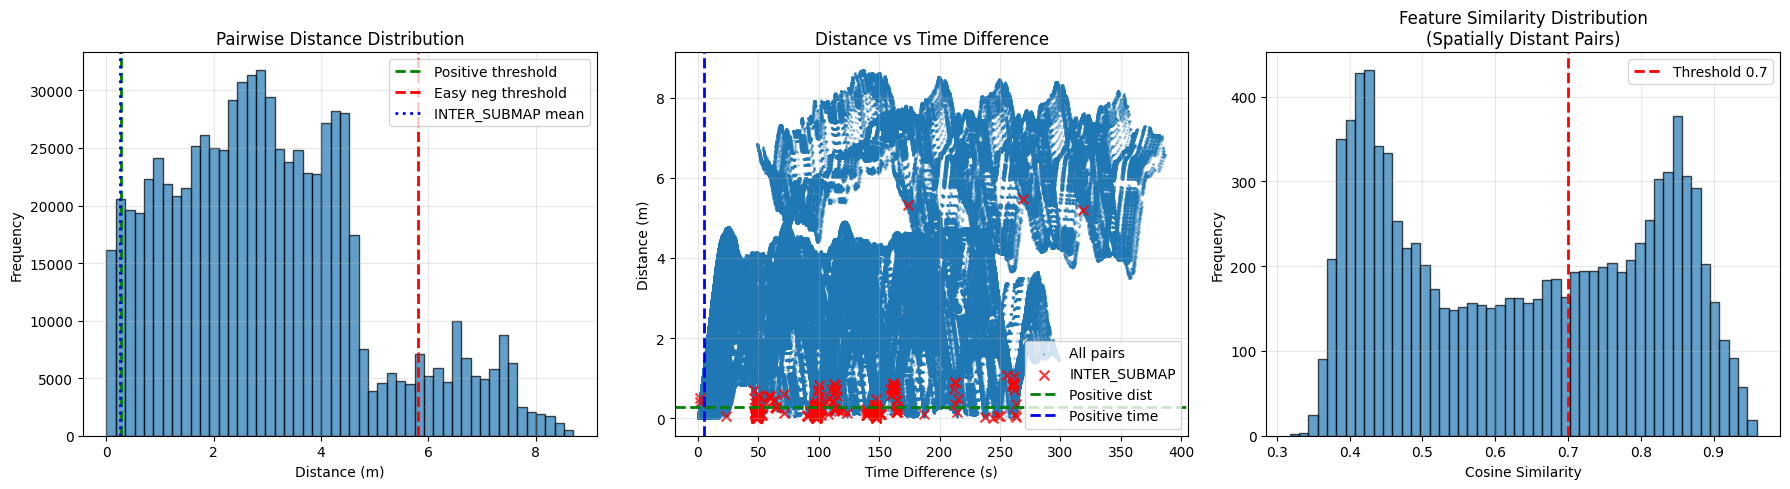


✓ Profiling complete. Proceeding with configured thresholds.


In [67]:
print("\n" + "="*70)
print("DATA PROFILING & THRESHOLD SUGGESTION")
print("="*70)


# Configuration: Threshold percentiles (adjustable)
POSITIVE_DISTANCE_PERCENTILE = 75  # Percentile of INTER_SUBMAP distances (75 = 75th percentile)
EASY_NEGATIVE_DISTANCE_PERCENTILE = 90  # Percentile of all pair distances


# Filter df_all_pairs to only include complete alignment nodes (both sensors)
complete_alignments = time_alignments.dropna()
valid_node_ids = set(complete_alignments['node_id'].values)
df_pairs_valid = df_all_pairs[
    df_all_pairs['node1_id'].isin(valid_node_ids) &
    df_all_pairs['node2_id'].isin(valid_node_ids)
].copy()

print(f"\nPairwise data:")
print(f"  Total pairs: {len(df_all_pairs):,}")
print(f"  Complete alignment nodes: {len(complete_alignments)} / {len(time_alignments)}")
print(f"  Valid pairs (both nodes complete): {len(df_pairs_valid):,}")

# Calculate statistics for ALL valid pairs
distances = df_pairs_valid['distance_between_nodes_m'].values
time_diffs = df_pairs_valid['time_diff_secs'].values

# Distance percentiles (FIXED - correct indexing)
dist_percentiles = [5, 10, 25, 50, 75, 90, 95]
dist_values = np.percentile(distances, dist_percentiles)

print(f"\n📊 Distance Distribution - ALL PAIRS (meters):")
for p, v in zip(dist_percentiles, dist_values):
    print(f"  {p:2d}th percentile: {v:.3f}m")

# Time percentiles
time_percentiles = [5, 10, 25, 50, 75, 90, 95]
time_values = np.percentile(time_diffs, time_percentiles)

print(f"\n⏱️  Time Difference Distribution - ALL PAIRS (seconds):")
for p, v in zip(time_percentiles, time_values):
    print(f"  {p:2d}th percentile: {v:.1f}s")

print("\n" + "="*70)
print("INTER_SUBMAP CONSTRAINT ANALYSIS (Ground Truth)")
print("="*70)

# Analyze INTER_SUBMAP pairs specifically
inter_submap_pairs = df_pairs_valid[df_pairs_valid['loop_closure'] == 1]

print(f"\n🎯 INTER_SUBMAP Loop Closures:")
print(f"  Count: {len(inter_submap_pairs)}")

if len(inter_submap_pairs) > 0:
    inter_distances = inter_submap_pairs['distance_between_nodes_m'].values
    inter_times = inter_submap_pairs['time_diff_secs'].values

    print(f"\n  Distance statistics:")
    print(f"    Min:  {np.min(inter_distances):.3f}m")
    print(f"    Max:  {np.max(inter_distances):.3f}m")
    print(f"    Mean: {np.mean(inter_distances):.3f}m")
    print(f"    Std:  {np.std(inter_distances):.3f}m")

    print(f"\n  Time gap statistics:")
    print(f"    Min:  {np.min(inter_times):.1f}s")
    print(f"    Max:  {np.max(inter_times):.1f}s")
    print(f"    Mean: {np.mean(inter_times):.1f}s")
    print(f"    Std:  {np.std(inter_times):.1f}s")

    # Suggest thresholds based on INTER_SUBMAP characteristics
    suggested_positive_dist = np.percentile(inter_distances, POSITIVE_DISTANCE_PERCENTILE) + 0.05  # Configurable percentile + margin
    suggested_time_gap = max(5.0, np.min(inter_times) - 2.0)  # Min - margin, but at least 5s

    print(f"\n💡 Suggested Thresholds (based on INTER_SUBMAP):")
    print(f"  Positive distance: {suggested_positive_dist:.3f}m (INTER_SUBMAP {POSITIVE_DISTANCE_PERCENTILE}th percentile + 0.05m)")
    print(f"  Positive time gap: {suggested_time_gap:.1f}s (INTER_SUBMAP min - 2s)")
else:
    print("  ⚠️  WARNING: No INTER_SUBMAP constraints found!")
    suggested_positive_dist = POSITIVE_DISTANCE_THRESHOLD
    suggested_time_gap = POSITIVE_TIME_GAP

# Use 90th percentile for easy negative threshold
suggested_easy_neg_dist = np.percentile(distances, EASY_NEGATIVE_DISTANCE_PERCENTILE)

print(f"  Easy negative distance: {suggested_easy_neg_dist:.3f}m ({EASY_NEGATIVE_DISTANCE_PERCENTILE}th percentile of all pairs)")

print(f"\n{'='*70}")
print("AUTO-APPLYING SUGGESTED THRESHOLDS")
print(f"{'='*70}")

# Store original values
original_positive_dist = POSITIVE_DISTANCE_THRESHOLD
original_positive_time = POSITIVE_TIME_GAP
original_easy_neg_dist = EASY_NEGATIVE_MIN_DISTANCE

# Apply suggested thresholds
POSITIVE_DISTANCE_THRESHOLD = suggested_positive_dist
POSITIVE_TIME_GAP = suggested_time_gap
EASY_NEGATIVE_MIN_DISTANCE = suggested_easy_neg_dist

print(f"\n📝 Threshold Updates:")
print(f"\n  Positive Distance:")
print(f"    Before: {original_positive_dist:.3f}m")
print(f"    After:  {POSITIVE_DISTANCE_THRESHOLD:.3f}m")
print(f"    Change: {POSITIVE_DISTANCE_THRESHOLD - original_positive_dist:+.3f}m ({100*(POSITIVE_DISTANCE_THRESHOLD - original_positive_dist)/original_positive_dist:+.1f}%)")

print(f"\n  Positive Time Gap:")
print(f"    Before: {original_positive_time:.1f}s")
print(f"    After:  {POSITIVE_TIME_GAP:.1f}s")
print(f"    Change: {POSITIVE_TIME_GAP - original_positive_time:+.1f}s ({100*(POSITIVE_TIME_GAP - original_positive_time)/original_positive_time:+.1f}%)")

print(f"\n  Easy Negative Distance:")
print(f"    Before: {original_easy_neg_dist:.3f}m")
print(f"    After:  {EASY_NEGATIVE_MIN_DISTANCE:.3f}m")
print(f"    Change: {EASY_NEGATIVE_MIN_DISTANCE - original_easy_neg_dist:+.3f}m ({100*(EASY_NEGATIVE_MIN_DISTANCE - original_easy_neg_dist)/original_easy_neg_dist:+.1f}%)")

print(f"\n📊 Threshold Sources:")
print(f"  Positive distance: INTER_SUBMAP {POSITIVE_DISTANCE_PERCENTILE}th percentile + 0.05m safety margin")
print(f"  Positive time gap: INTER_SUBMAP min - 2s safety margin (≥5s floor)")
print(f"  Easy negative distance: {EASY_NEGATIVE_DISTANCE_PERCENTILE}th percentile of all pair distances")

# Calculate adaptive hard negative distance threshold
suggested_hard_neg_dist = np.median(distances)
original_hard_neg_dist = HARD_NEGATIVE_MIN_DISTANCE
HARD_NEGATIVE_MIN_DISTANCE = suggested_hard_neg_dist

print(f"\n  Hard Negative Distance:")
print(f"    Before: {original_hard_neg_dist:.3f}m")
print(f"    After:  {HARD_NEGATIVE_MIN_DISTANCE:.3f}m (median of all pairs)")
print(f"    Change: {HARD_NEGATIVE_MIN_DISTANCE - original_hard_neg_dist:+.3f}m ({100*(HARD_NEGATIVE_MIN_DISTANCE - original_hard_neg_dist)/original_hard_neg_dist:+.1f}%)")

print(f"\n✅ Thresholds updated - proceeding with data-driven values")

print(f"\n📝 Current Configuration:")
print(f"  Positive distance: {POSITIVE_DISTANCE_THRESHOLD:.3f}m")
print(f"  Easy negative distance: {EASY_NEGATIVE_MIN_DISTANCE:.3f}m")
print(f"  Hard negative distance: {HARD_NEGATIVE_MIN_DISTANCE:.3f}m")
print(f"  Positive time gap: {POSITIVE_TIME_GAP:.1f}s")

print("\n" + "="*70)
print("POSITIVE PAIRS ANALYSIS")
print("="*70)

# Analyze potential positives with current thresholds
potential_positives_current = df_pairs_valid[
    (df_pairs_valid['distance_between_nodes_m'] <= POSITIVE_DISTANCE_THRESHOLD) &
    (df_pairs_valid['time_diff_secs'] >= POSITIVE_TIME_GAP)
]
extra_candidates_current = potential_positives_current[potential_positives_current['loop_closure'] == 0]

print(f"\n🔧 With CURRENT thresholds:")
print(f"  Distance ≤ {POSITIVE_DISTANCE_THRESHOLD}m AND Time gap ≥ {POSITIVE_TIME_GAP}s")
print(f"  Total meeting criteria: {len(potential_positives_current)}")
print(f"  Validated INTER_SUBMAP: {len(inter_submap_pairs)}")
print(f"  Extra candidates (not INTER_SUBMAP): {len(extra_candidates_current)}")

if len(extra_candidates_current) > 0:
    print(f"    Distance - Mean: {extra_candidates_current['distance_between_nodes_m'].mean():.3f}m")
    print(f"    Time gap - Mean: {extra_candidates_current['time_diff_secs'].mean():.1f}s")

print("\n" + "="*70)
print("NEGATIVE PAIRS PROFILING")
print("="*70)

# Easy negatives pool
easy_neg_candidates = df_pairs_valid[
    (df_pairs_valid['distance_between_nodes_m'] > EASY_NEGATIVE_MIN_DISTANCE) &
    (df_pairs_valid['time_diff_secs'] > EASY_NEG_MIN_TEMPORAL_GAP)
]

print(f"\n📦 Easy Negative Pool:")
print(f"  Criteria: Distance > {EASY_NEGATIVE_MIN_DISTANCE}m AND Time gap > {EASY_NEG_MIN_TEMPORAL_GAP}s")
print(f"  Available candidates: {len(easy_neg_candidates):,}")

# Distance bin distribution
for i in range(len(STRATIFY_DISTANCE_BINS) - 1):
    bin_start = STRATIFY_DISTANCE_BINS[i]
    bin_end = STRATIFY_DISTANCE_BINS[i+1]
    if bin_end == np.inf:
        bin_count = len(easy_neg_candidates[easy_neg_candidates['distance_between_nodes_m'] >= bin_start])
        print(f"    {bin_start:.1f}m+ : {bin_count:,} pairs")
    else:
        bin_count = len(easy_neg_candidates[
            (easy_neg_candidates['distance_between_nodes_m'] >= bin_start) &
            (easy_neg_candidates['distance_between_nodes_m'] < bin_end)
        ])
        print(f"    {bin_start:.1f}-{bin_end:.1f}m: {bin_count:,} pairs")

# Hard negatives pool profiling
print(f"\n🎯 Hard Negative Pool Profiling:")
print(f"  Computing similarities for distance > {EASY_NEGATIVE_MIN_DISTANCE}m pairs...")

hard_neg_base = df_pairs_valid[
    df_pairs_valid['distance_between_nodes_m'] > EASY_NEGATIVE_MIN_DISTANCE
]

# Sample for profiling (if too many, sample 10k for speed)
profile_sample = hard_neg_base.sample(n=min(10000, len(hard_neg_base)), random_state=RANDOM_SEED)

similarities = []
for _, row in profile_sample.iterrows():
    node1_data = time_alignments[time_alignments['node_id'] == row['node1_id']].iloc[0]
    node2_data = time_alignments[time_alignments['node_id'] == row['node2_id']].iloc[0]

    cam1_idx = int(node1_data['camera_feat_id'])
    lid1_idx = int(node1_data['lidar_feat_id'])
    cam2_idx = int(node2_data['camera_feat_id'])
    lid2_idx = int(node2_data['lidar_feat_id'])

    feat1 = np.concatenate([camera_features[cam1_idx], lidar_features[lid1_idx]])
    feat2 = np.concatenate([camera_features[cam2_idx], lidar_features[lid2_idx]])

    similarity = np.dot(feat1, feat2) / (np.linalg.norm(feat1) * np.linalg.norm(feat2))
    similarities.append(similarity)

similarities = np.array(similarities)

print(f"  Similarity distribution (sampled {len(similarities):,} pairs):")
sim_percentiles = [50, 75, 90, 95, 99]
sim_values = np.percentile(similarities, sim_percentiles)
for p, v in zip(sim_percentiles, sim_values):
    print(f"    {p:2d}th percentile: {v:.3f}")

# Estimate hard negatives at each threshold
print(f"\n  Estimated hard negatives at different thresholds:")
total_hard_base = len(hard_neg_base)
for threshold in HARD_NEGATIVE_SIMILARITY_FALLBACK:
    estimated_count = int(total_hard_base * np.mean(similarities >= threshold))
    print(f"    Similarity ≥ {threshold:.2f}: ~{estimated_count:,} pairs")

print("\n" + "="*70)
print("SAMPLING PLAN (Option 2: Hard-focused)")
print("="*70)

n_positives = len(potential_positives_current)
n_easy_neg_target = int(n_positives * EASY_NEGATIVE_RATIO)
n_hard_neg_target = int(n_positives * HARD_NEGATIVE_RATIO)
total_dataset_size = n_positives + n_easy_neg_target + n_hard_neg_target

print(f"\n📊 Target Dataset Composition:")
print(f"  Positives:      {n_positives:4d} (30.0%)")
print(f"  Easy negatives: {n_easy_neg_target:4d} ({100*n_easy_neg_target/total_dataset_size:.1f}%)")
print(f"  Hard negatives: {n_hard_neg_target:4d} ({100*n_hard_neg_target/total_dataset_size:.1f}%)")
print(f"  ──────────────────────────")
print(f"  Total:          {total_dataset_size:4d} pairs")

print(f"\n✅ Feasibility Check:")
print(f"  Easy neg available: {len(easy_neg_candidates):,} (need {n_easy_neg_target}) → {'✓' if len(easy_neg_candidates) >= n_easy_neg_target else '⚠️ INSUFFICIENT'}")

# Estimate if we have enough hard negatives at base threshold
estimated_hard_at_base = int(total_hard_base * np.mean(similarities >= HARD_NEGATIVE_SIMILARITY_THRESHOLD))
print(f"  Hard neg available: ~{estimated_hard_at_base:,} (need {n_hard_neg_target}) → {'✓' if estimated_hard_at_base >= n_hard_neg_target else '⚠️ MAY NEED FALLBACK'}")

# Visualization
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Distance histogram
axes[0].hist(distances, bins=50, alpha=0.7, edgecolor='black')
axes[0].axvline(POSITIVE_DISTANCE_THRESHOLD, color='green', linestyle='--', linewidth=2, label='Positive threshold')
axes[0].axvline(EASY_NEGATIVE_MIN_DISTANCE, color='red', linestyle='--', linewidth=2, label='Easy neg threshold')
if len(inter_submap_pairs) > 0:
    axes[0].axvline(np.mean(inter_distances), color='blue', linestyle=':', linewidth=2, label='INTER_SUBMAP mean')
axes[0].set_xlabel('Distance (m)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Pairwise Distance Distribution')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Time vs Distance scatter
axes[1].scatter(time_diffs, distances, alpha=0.3, s=1, label='All pairs')
if len(inter_submap_pairs) > 0:
    axes[1].scatter(inter_times, inter_distances, alpha=0.8, s=50, c='red', marker='x', label='INTER_SUBMAP')
axes[1].axhline(POSITIVE_DISTANCE_THRESHOLD, color='green', linestyle='--', linewidth=2, label='Positive dist')
axes[1].axvline(POSITIVE_TIME_GAP, color='blue', linestyle='--', linewidth=2, label='Positive time')
axes[1].set_xlabel('Time Difference (s)')
axes[1].set_ylabel('Distance (m)')
axes[1].set_title('Distance vs Time Difference')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Similarity histogram for hard negatives
axes[2].hist(similarities, bins=50, alpha=0.7, edgecolor='black')
axes[2].axvline(HARD_NEGATIVE_SIMILARITY_THRESHOLD, color='red', linestyle='--', linewidth=2, label=f'Threshold {HARD_NEGATIVE_SIMILARITY_THRESHOLD}')
axes[2].set_xlabel('Cosine Similarity')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Feature Similarity Distribution\n(Spatially Distant Pairs)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("✓ Profiling complete. Proceeding with configured thresholds.")
print("="*70)

### 6.2 Strategy Overview

We create three types of training pairs using **Option 2: Hard-focused ratios**:

1. **Positive Pairs (30%)** - Loop closures from Cartographer-optimized trajectory
   - Based on final SLAM-corrected positions (distance ≤ 0.3m, time gap ≥ 10s)
   - Includes INTER_SUBMAP validated + augmented candidates from trajectory analysis
   
2. **Easy Negative Pairs (~22%)** - Spatially distant locations
   - **Ratio: 0.75x positives**
   - Distance > 1.0m with temporal gap > 5s
   - Stratified sampling by distance bins for diversity
   
3. **Hard Negative Pairs (~48%)** - Perceptually similar but spatially distinct
   - **Ratio: 1.25x positives**
   - Distance > 1.0m AND high feature similarity (≥ 0.7)
   - Fallback thresholds if insufficient: [0.7, 0.65, 0.6, 0.55]
   - Teaches model to avoid perceptual aliasing

**Rationale:** More hard negatives help the model learn robust discrimination in ambiguous cases, which is critical for reliable loop closure detection.

### 6.3 Generate Positive Pairs from Loop Closures

In [68]:
print("\n" + "="*70)
print("GENERATING POSITIVE PAIR LABELS - PART 1: LOOP CLOSURES")
print("="*70)

# Step 1: Get INTER_SUBMAP loop closures as first set of positives
loop_closure_pairs = df_all_pairs[df_all_pairs['loop_closure'] == True].copy()

# Create DataFrame with node_pair_id (as integer) and label
labeled_pairs_loop_closure = pd.DataFrame({
    'node_pair_id': loop_closure_pairs.index.astype(int),
    'label': 1,
    'source': 'loop_closure'
})

n_loop_closure = len(labeled_pairs_loop_closure)
print(f"\n✓ Loop closure positives: {n_loop_closure}")

# Track used indices
used_indices = set(labeled_pairs_loop_closure['node_pair_id'].values)



GENERATING POSITIVE PAIR LABELS - PART 1: LOOP CLOSURES

✓ Loop closure positives: 406


In [69]:
print("\n" + "="*70)
print("GENERATING POSITIVE PAIR LABELS - PART 2: AUGMENTED POSITIVES")
print("="*70)

# Step 2: Get augmented positives (distance + time criteria, excluding loop closures)
remaining_indices = df_all_pairs.index.difference(used_indices)
candidates = df_all_pairs.loc[remaining_indices]

# Apply positive criteria
augmented_mask = (
    (candidates['distance_between_nodes_m'] < POSITIVE_DISTANCE_THRESHOLD) &
    (candidates['time_diff_secs'] > POSITIVE_TIME_GAP)
)

augmented_positives = candidates[augmented_mask].copy()

# Create DataFrame
labeled_pairs_augmented = pd.DataFrame({
    'node_pair_id': augmented_positives.index.astype(int),
    'label': 1,
    'source': 'augmented',
    'distance': augmented_positives['distance_between_nodes_m'].values,
    'time_diff': augmented_positives['time_diff_secs'].values
})

n_augmented = len(labeled_pairs_augmented)
print(f"\n✓ Augmented positives: {n_augmented}")
print(f"  Distance < {POSITIVE_DISTANCE_THRESHOLD}m, Time gap > {POSITIVE_TIME_GAP}s")

# Combine both positive sets
labeled_pairs_positive = pd.concat([
    labeled_pairs_loop_closure,
    labeled_pairs_augmented
], ignore_index=True)

print(f"\n✅ Total positives: {len(labeled_pairs_positive)} ({n_loop_closure} loop closure + {n_augmented} augmented)")

# Update used indices
used_indices.update(labeled_pairs_positive['node_pair_id'].values)



GENERATING POSITIVE PAIR LABELS - PART 2: AUGMENTED POSITIVES

✓ Augmented positives: 19322
  Distance < 0.2777539391674729m, Time gap > 5.0s

✅ Total positives: 19728 (406 loop closure + 19322 augmented)


### 6.4 Generate Easy Negative Pairs

In [70]:
print("\n" + "="*70)
print("GENERATING EASY NEGATIVE PAIR LABELS")
print("="*70)

# Step 3: Get easy negatives (exclude all positives)
n_easy_neg_target = int(len(labeled_pairs_positive) * EASY_NEGATIVE_RATIO)

remaining_indices = df_all_pairs.index.difference(used_indices)
candidates = df_all_pairs.loc[remaining_indices]

# Apply easy negative criteria
easy_neg_mask = (
    (candidates['distance_between_nodes_m'] > EASY_NEGATIVE_MIN_DISTANCE) &
    (candidates['time_diff_secs'] > POSITIVE_TIME_GAP)
)

easy_neg_candidates = candidates[easy_neg_mask].copy()

print(f"\nTarget count: {n_easy_neg_target} ({EASY_NEGATIVE_RATIO}x positives)")
print(f"Available candidates: {len(easy_neg_candidates)}")

if len(easy_neg_candidates) < n_easy_neg_target:
    print(f"⚠️  Warning: Insufficient candidates. Using all {len(easy_neg_candidates)} available.")
    easy_neg_sample = easy_neg_candidates
else:
    # Stratified sampling by distance bins
    distances = easy_neg_candidates['distance_between_nodes_m'].values
    bins = [EASY_NEGATIVE_MIN_DISTANCE, 2.0, 4.0, 6.0, np.inf]

    samples_per_bin = []
    for i in range(len(bins)-1):
        bin_start, bin_end = bins[i], bins[i+1]
        bin_mask = (distances >= bin_start) & (distances < bin_end)
        bin_data = easy_neg_candidates[bin_mask]

        bin_target = int(n_easy_neg_target * len(bin_data) / len(easy_neg_candidates))
        bin_target = min(bin_target, len(bin_data))

        if bin_target > 0:
            sample = bin_data.sample(n=bin_target, random_state=RANDOM_SEED)
            samples_per_bin.append(sample)

    easy_neg_sample = pd.concat(samples_per_bin, ignore_index=False)

# Create DataFrame
labeled_pairs_easy = pd.DataFrame({
    'node_pair_id': easy_neg_sample.index.astype(int),
    'label': 0,
    'source': 'easy_negative',
    'distance': easy_neg_sample['distance_between_nodes_m'].values
})

print(f"\n✅ Generated {len(labeled_pairs_easy)} easy negative pair labels")

# Update used indices
used_indices.update(labeled_pairs_easy['node_pair_id'].values)



GENERATING EASY NEGATIVE PAIR LABELS

Target count: 14796 (0.75x positives)
Available candidates: 77710

✅ Generated 14795 easy negative pair labels


### 6.5 Generate Hard Negative Pairs (Perceptual Aliasing)

In [71]:
print("\n" + "="*70)
print("GENERATING HARD NEGATIVE PAIR LABELS (PERCEPTUAL ALIASING)")
print("="*70)

# Step 4: Get hard negatives (exclude all positives and easy negatives)
n_hard_neg_target = int(len(labeled_pairs_positive) * HARD_NEGATIVE_RATIO)

remaining_indices = df_all_pairs.index.difference(used_indices)
candidates = df_all_pairs.loc[remaining_indices]

print(f"\nTarget count: {n_hard_neg_target} ({HARD_NEGATIVE_RATIO}x positives)")
print(f"Remaining candidate pairs: {len(candidates)}")

# Filter by distance
distance_mask = candidates['distance_between_nodes_m'] > HARD_NEGATIVE_MIN_DISTANCE
candidates_filtered = candidates[distance_mask]

print(f"After distance filter (>{HARD_NEGATIVE_MIN_DISTANCE:.3f}m): {len(candidates_filtered)}")

if len(candidates_filtered) == 0:
    print("\n⚠️  No candidates after distance filter. Creating empty hard negatives.")
    labeled_pairs_hard = pd.DataFrame(columns=['node_pair_id', 'label', 'source'])
    similarities_selected = np.array([])
else:
    # Vectorized batch processing with fallback thresholds
    hard_negative_candidates = []
    batch_size = 50000
    fallback_thresholds = HARD_NEGATIVE_SIMILARITY_FALLBACK  # [0.70, 0.65, 0.60, 0.55]

    print(f"\nVectorized batch processing (batch_size={batch_size})...")

    # Try each threshold until target reached
    for threshold in fallback_thresholds:
        if len(hard_negative_candidates) >= n_hard_neg_target:
            break

        print(f"\nAttempting similarity threshold ≥ {threshold:.2f}...")
        attempts = 0
        max_attempts = 10  # Maximum batches per threshold

        while len(hard_negative_candidates) < n_hard_neg_target and attempts < max_attempts:
            attempts += 1

            # Random sample from candidates
            sample_size = min(batch_size, len(candidates_filtered))
            batch_candidates = candidates_filtered.sample(n=sample_size, random_state=RANDOM_SEED+attempts)

            # Build feature matrices for batch
            batch_features_1 = []
            batch_features_2 = []
            batch_indices = []

            for pair_idx, row in batch_candidates.iterrows():
                try:
                    node1_id = int(row['node1_id'])
                    node2_id = int(row['node2_id'])

                    node1_align = time_alignments[time_alignments['node_id'] == node1_id].iloc[0]
                    node2_align = time_alignments[time_alignments['node_id'] == node2_id].iloc[0]

                    # Check for NaN
                    if pd.isna(node1_align['camera_feat_id']) or pd.isna(node1_align['lidar_feat_id']) or \
                       pd.isna(node2_align['camera_feat_id']) or pd.isna(node2_align['lidar_feat_id']):
                        continue

                    cam1_idx = int(node1_align['camera_feat_id'])
                    lid1_idx = int(node1_align['lidar_feat_id'])
                    cam2_idx = int(node2_align['camera_feat_id'])
                    lid2_idx = int(node2_align['lidar_feat_id'])

                    feat1 = np.concatenate([camera_features[cam1_idx], lidar_features[lid1_idx]])
                    feat2 = np.concatenate([camera_features[cam2_idx], lidar_features[lid2_idx]])

                    batch_features_1.append(feat1)
                    batch_features_2.append(feat2)
                    batch_indices.append(pair_idx)
                except:
                    continue

            if len(batch_features_1) == 0:
                continue

            # Vectorized similarity computation
            batch_features_1 = np.array(batch_features_1)
            batch_features_2 = np.array(batch_features_2)

            # Compute cosine similarity (vectorized)
            norms_1 = np.linalg.norm(batch_features_1, axis=1, keepdims=True)
            norms_2 = np.linalg.norm(batch_features_2, axis=1, keepdims=True)
            similarities = np.sum(batch_features_1 * batch_features_2, axis=1) / (norms_1.flatten() * norms_2.flatten())

            # Filter by threshold
            high_sim_mask = similarities >= threshold
            high_sim_indices = np.array(batch_indices)[high_sim_mask]
            high_sim_values = similarities[high_sim_mask]

            # Add to candidates
            for idx, sim in zip(high_sim_indices, high_sim_values):
                if int(idx) not in [c['node_pair_id'] for c in hard_negative_candidates]:
                    hard_negative_candidates.append({
                        'node_pair_id': int(idx),
                        'similarity': float(sim)
                    })

                    if len(hard_negative_candidates) >= n_hard_neg_target:
                        break

            print(f"  Batch {attempts}: Found {len(high_sim_indices)} candidates (Total: {len(hard_negative_candidates)}/{n_hard_neg_target})")

            if len(hard_negative_candidates) >= n_hard_neg_target:
                break

        if len(hard_negative_candidates) >= n_hard_neg_target:
            print(f"\n✅ Target reached with threshold {threshold:.2f}")
            break
        else:
            print(f"  Found {len(hard_negative_candidates)} so far, trying lower threshold...")

    # Create DataFrame
    if len(hard_negative_candidates) > 0:
        # Trim to exact target (with tolerance)
        tolerance = int(n_hard_neg_target * 0.05)  # ±5%
        max_count = n_hard_neg_target + tolerance
        hard_negative_candidates = hard_negative_candidates[:max_count]

        labeled_pairs_hard = pd.DataFrame(hard_negative_candidates)
        labeled_pairs_hard['node_pair_id'] = labeled_pairs_hard['node_pair_id'].astype(int)
        labeled_pairs_hard['label'] = 0
        labeled_pairs_hard['source'] = 'hard_negative'
        similarities_selected = labeled_pairs_hard['similarity'].values

        print(f"\n✅ Generated {len(labeled_pairs_hard)} hard negative pair labels")
        print(f"  Similarity range: [{similarities_selected.min():.3f}, {similarities_selected.max():.3f}]")
        print(f"  Mean similarity: {similarities_selected.mean():.3f}")
        print(f"  Target achievement: {len(labeled_pairs_hard)/n_hard_neg_target*100:.1f}%")
    else:
        print("\n⚠️  No hard negatives found meeting criteria.")
        labeled_pairs_hard = pd.DataFrame(columns=['node_pair_id', 'label', 'source', 'similarity'])
        similarities_selected = np.array([])

# Update used indices
if len(labeled_pairs_hard) > 0:
    used_indices.update(labeled_pairs_hard['node_pair_id'].values)



GENERATING HARD NEGATIVE PAIR LABELS (PERCEPTUAL ALIASING)

Target count: 24660 (1.25x positives)
Remaining candidate pairs: 752362
After distance filter (>2.821m): 373553

Vectorized batch processing (batch_size=50000)...

Attempting similarity threshold ≥ 0.70...
  Batch 1: Found 6992 candidates (Total: 6992/24660)
  Batch 2: Found 6917 candidates (Total: 12961/24660)
  Batch 3: Found 6881 candidates (Total: 18108/24660)
  Batch 4: Found 7016 candidates (Total: 22672/24660)
  Batch 5: Found 7062 candidates (Total: 24660/24660)

✅ Target reached with threshold 0.70

✅ Generated 24660 hard negative pair labels
  Similarity range: [0.700, 0.973]
  Mean similarity: 0.813
  Target achievement: 100.0%


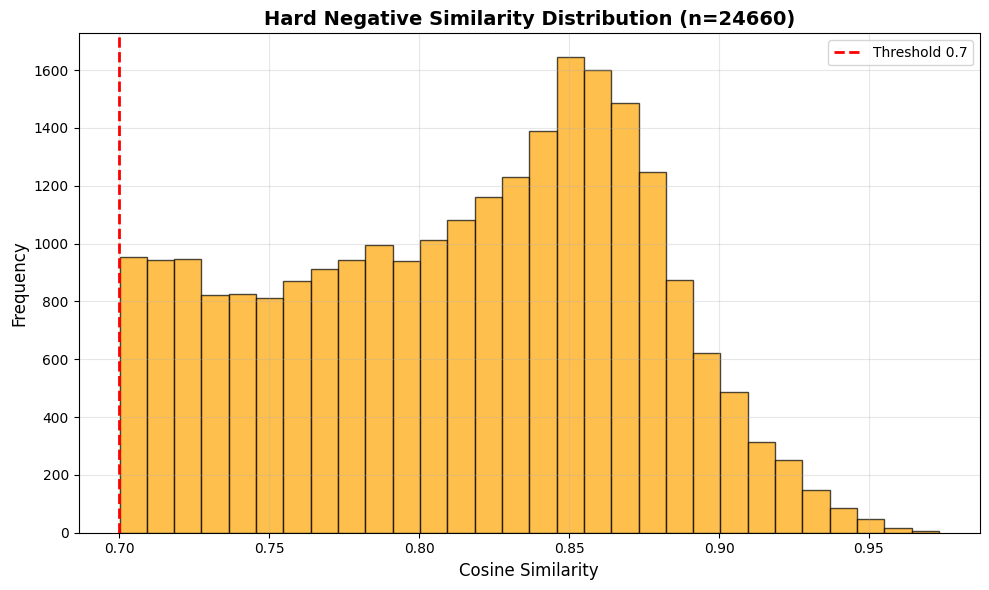


✅ Hard negative similarity plot generated


In [72]:
# Visualize Hard Negative Similarity Distribution
if len(labeled_pairs_hard) > 0 and 'similarity' in labeled_pairs_hard.columns:
    plt.figure(figsize=(10, 6))
    plt.hist(labeled_pairs_hard['similarity'].values, bins=30, alpha=0.7, color='orange', edgecolor='black')
    plt.axvline(HARD_NEGATIVE_SIMILARITY_THRESHOLD, color='red', linestyle='--', linewidth=2,
                label=f'Threshold {HARD_NEGATIVE_SIMILARITY_THRESHOLD}')
    plt.xlabel('Cosine Similarity', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title(f'Hard Negative Similarity Distribution (n={len(labeled_pairs_hard)})', fontsize=14, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    print(f"\n✅ Hard negative similarity plot generated")
else:
    print(f"\n⚠️ No similarity data available for hard negatives")


### 6.6 Combine and Shuffle Dataset

In [73]:
print("\n" + "="*70)
print("COMBINING LABELED PAIRS")
print("="*70)

# Drop extra columns from each dataframe, keeping only node_pair_id and label
labeled_pairs_positive_clean = labeled_pairs_positive[['node_pair_id', 'label']].copy()
labeled_pairs_easy_clean = labeled_pairs_easy[['node_pair_id', 'label']].copy()
labeled_pairs_hard_clean = labeled_pairs_hard[['node_pair_id', 'label']].copy()

# Ensure node_pair_id is integer
labeled_pairs_positive_clean['node_pair_id'] = labeled_pairs_positive_clean['node_pair_id'].astype(int)
labeled_pairs_easy_clean['node_pair_id'] = labeled_pairs_easy_clean['node_pair_id'].astype(int)
labeled_pairs_hard_clean['node_pair_id'] = labeled_pairs_hard_clean['node_pair_id'].astype(int)

# Combine all labeled pairs into single DataFrame
labeled_pairs = pd.concat([
    labeled_pairs_positive_clean,
    labeled_pairs_easy_clean,
    labeled_pairs_hard_clean
], ignore_index=True)

print(f"\n✅ Labeled pairs combined:")
print(f"   Total pairs: {len(labeled_pairs)}")
print(f"\n   Positive:      {len(labeled_pairs_positive):5d} ({100*len(labeled_pairs_positive)/len(labeled_pairs):5.1f}%)")
print(f"   Easy negative: {len(labeled_pairs_easy):5d} ({100*len(labeled_pairs_easy)/len(labeled_pairs):5.1f}%)")
print(f"   Hard negative: {len(labeled_pairs_hard):5d} ({100*len(labeled_pairs_hard)/len(labeled_pairs):5.1f}%)")

actual_easy_ratio = len(labeled_pairs_easy) / len(labeled_pairs_positive) if len(labeled_pairs_positive) > 0 else 0
actual_hard_ratio = len(labeled_pairs_hard) / len(labeled_pairs_positive) if len(labeled_pairs_positive) > 0 else 0

print(f"\n   Actual ratios: {actual_easy_ratio:.2f}x easy / {actual_hard_ratio:.2f}x hard")
print(f"\n   DataFrame columns: {list(labeled_pairs.columns)}")
print(f"   Expected columns: ['node_pair_id', 'label']")

total = len(labeled_pairs)
n_positive = (labeled_pairs['label'] == 1).sum()
n_negative = (labeled_pairs['label'] == 0).sum()

print(f"\n   Label distribution: {n_positive} positive / {n_negative} negative")
print(f"\n💾 Labeled pairs ready for validation")



COMBINING LABELED PAIRS

✅ Labeled pairs combined:
   Total pairs: 59183

   Positive:      19728 ( 33.3%)
   Easy negative: 14795 ( 25.0%)
   Hard negative: 24660 ( 41.7%)

   Actual ratios: 0.75x easy / 1.25x hard

   DataFrame columns: ['node_pair_id', 'label']
   Expected columns: ['node_pair_id', 'label']

   Label distribution: 19728 positive / 39455 negative

💾 Labeled pairs ready for validation


In [74]:
print("\n" + "="*70)
print("SHUFFLING DATASET")
print("="*70)

# Shuffle the dataset
labeled_pairs = labeled_pairs.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

print(f"\n✅ Dataset shuffled (random_seed={RANDOM_SEED})")

# Display first 20 rows
print(f"\n📋 First 20 rows:")
display(labeled_pairs.head(20))

# Display last 20 rows
print(f"\n📋 Last 20 rows:")
display(labeled_pairs.tail(20))

# Quick label distribution check
first_20_pos = (labeled_pairs.head(20)['label'] == 1).sum()
last_20_pos = (labeled_pairs.tail(20)['label'] == 1).sum()
print(f"\n✓ First 20 rows: {first_20_pos} positive, {20-first_20_pos} negative")
print(f"✓ Last 20 rows: {last_20_pos} positive, {20-last_20_pos} negative")

print("="*70)



SHUFFLING DATASET

✅ Dataset shuffled (random_seed=42)

📋 First 20 rows:


,node_pair_id,label
0,292898,0
1,257914,0
2,77429,1
3,680366,0
4,441242,0
5,784783,1
6,48140,0
7,17359,0
8,497488,0
9,784585,1



📋 Last 20 rows:


,node_pair_id,label
59163,51534,1
59164,779397,0
59165,24560,1
59166,40550,1
59167,281803,0
59168,721585,1
59169,210628,0
59170,556690,0
59171,382322,0
59172,204901,0



✓ First 20 rows: 6 positive, 14 negative
✓ Last 20 rows: 9 positive, 11 negative


---

# SECTION 7: VALIDATIONS

Split, validate, visualize, report.

---



In [75]:
print("\n" + "="*70)
print("VALIDATING LABEL CONSISTENCY")
print("="*70)

# Check for duplicate node_pair_id values
duplicate_pairs = labeled_pairs[labeled_pairs.duplicated(subset=['node_pair_id'], keep=False)]

if len(duplicate_pairs) > 0:
    print(f"\n❌ ERROR: Found {len(duplicate_pairs)} duplicate node_pair_id entries!")
    print("\nDuplicate entries:")
    print(duplicate_pairs.sort_values('node_pair_id'))

    # Check for conflicting labels
    conflicting = duplicate_pairs.groupby('node_pair_id')['label'].nunique()
    conflicts = conflicting[conflicting > 1]

    if len(conflicts) > 0:
        print(f"\n❌ CRITICAL: {len(conflicts)} pairs have CONFLICTING LABELS!")
        for pair_id in conflicts.index:
            pair_data = labeled_pairs[labeled_pairs['node_pair_id'] == pair_id]
            print(f"  node_pair_id {pair_id}: labels = {pair_data['label'].tolist()}")
        raise ValueError("Dataset has pairs with conflicting labels!")
    else:
        print(f"\n⚠️  WARNING: Duplicates found but all have same label. Removing duplicates...")
        labeled_pairs = labeled_pairs.drop_duplicates(subset=['node_pair_id'], keep='first')
        print(f"✓ Removed duplicates. New size: {len(labeled_pairs)}")
else:
    print(f"\n✅ No duplicate node_pair_id entries found")

print(f"\n✅ Label consistency validated")
print("="*70)



VALIDATING LABEL CONSISTENCY

✅ No duplicate node_pair_id entries found

✅ Label consistency validated


### 7.1 Dataframes Visualitaions




DIAGNOSTIC VISUALIZATIONS (DATAFRAME-BASED)

Building feature matrix from dataframes...
Feature matrix built: (58916, 3072)
Valid pairs: 58916/59183

✅ Diagnostic plots (dataframe-based) saved: /content/drive/MyDrive/DATA/Artificial_Intelligence/MNA-V/Subjects/TC5035-Proyecto_Integrador/TC5035.data/jetbot/session_20251022_155137/dataset/dataset_diagnostics_dataframe.png


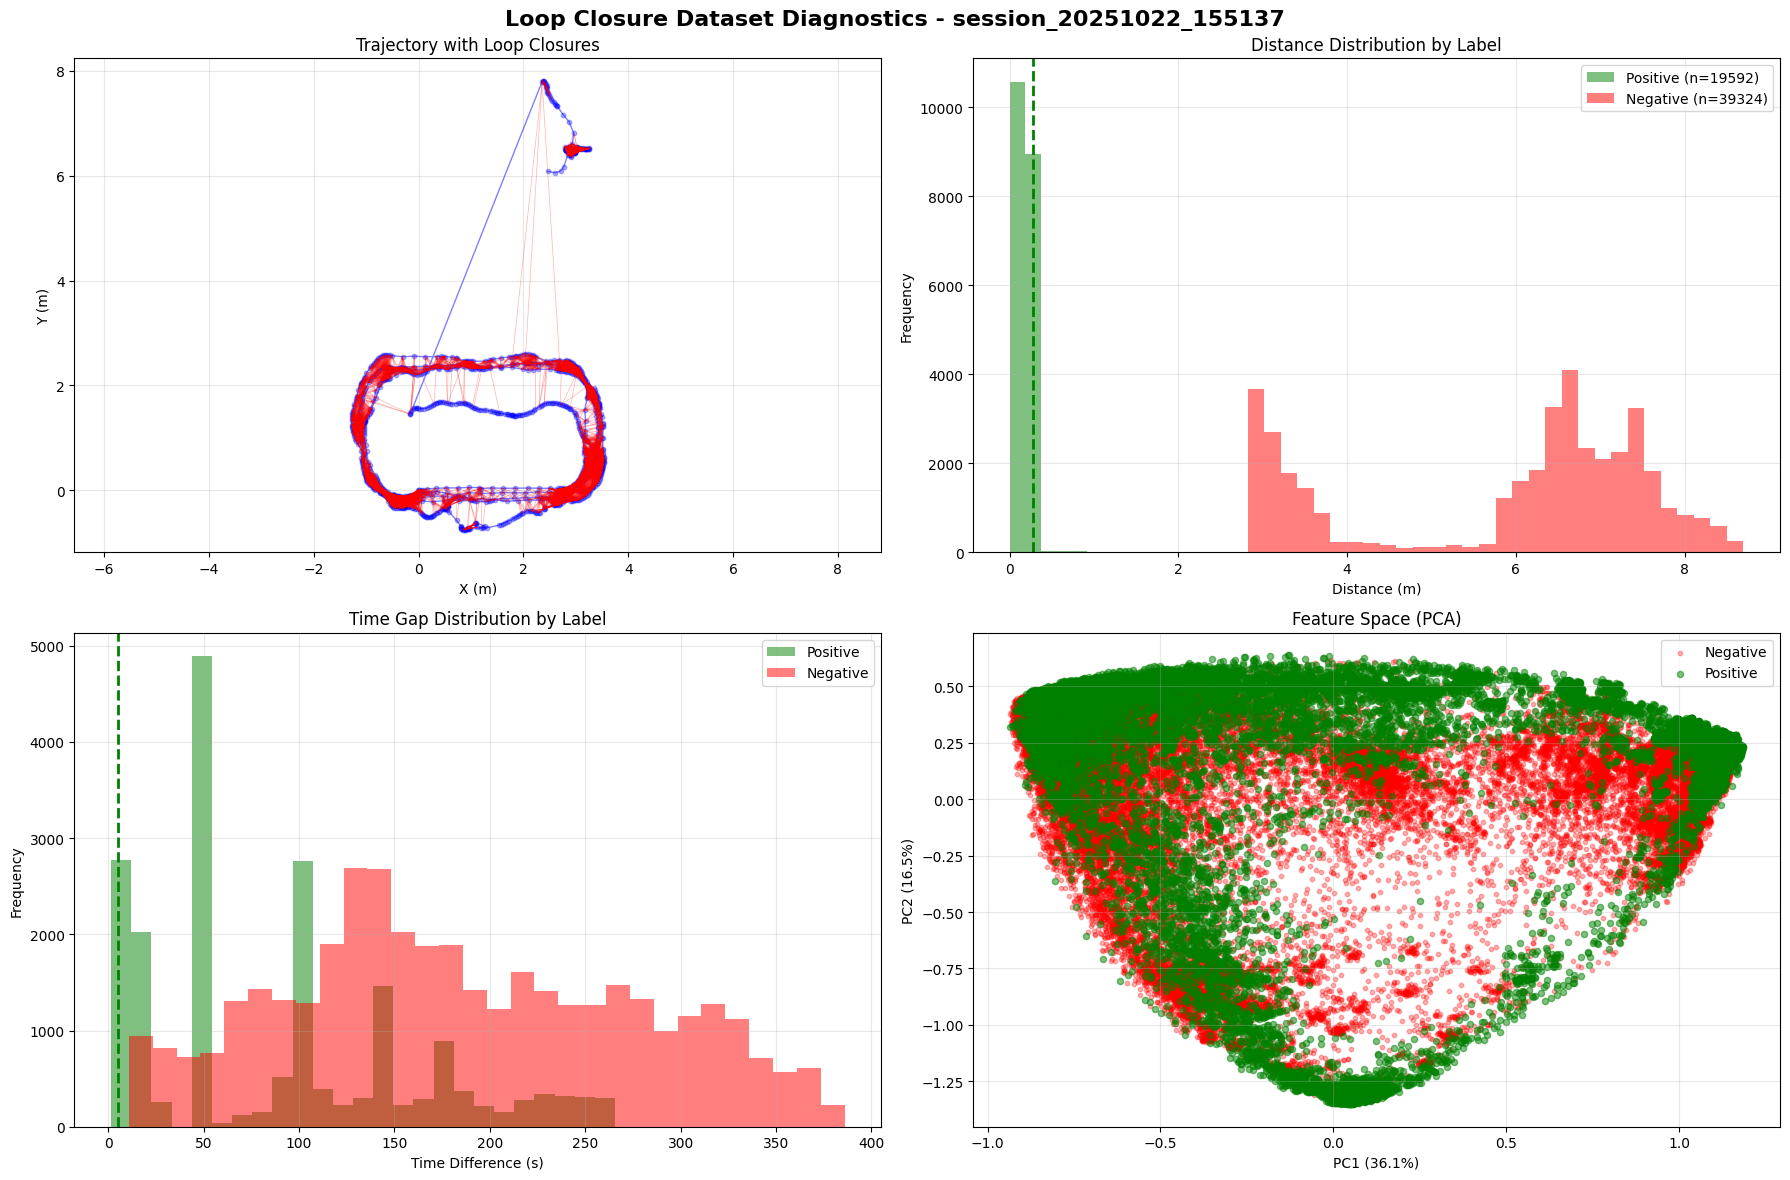

In [76]:
print("\n" + "="*70)
print("DIAGNOSTIC VISUALIZATIONS (DATAFRAME-BASED)")
print("="*70)

# Build feature matrix X and labels y from dataframes
print("\nBuilding feature matrix from dataframes...")

# Merge labeled_pairs with df_all_pairs to get node IDs and metrics
labeled_with_data = labeled_pairs.merge(df_all_pairs[['node1_id', 'node2_id', 'distance_between_nodes_m', 'time_diff_secs']],
                                         left_on='node_pair_id', right_index=True, how='left')

# Build feature matrix
X_list = []
y_list = []
valid_indices = []

for idx, row in labeled_with_data.iterrows():
    node1_id = int(row['node1_id'])
    node2_id = int(row['node2_id'])

    try:
        # Get alignment data
        node1_align = time_alignments[time_alignments['node_id'] == node1_id].iloc[0]
        node2_align = time_alignments[time_alignments['node_id'] == node2_id].iloc[0]

        # Check for NaN
        if pd.isna(node1_align['camera_feat_id']) or pd.isna(node1_align['lidar_feat_id']) or \
           pd.isna(node2_align['camera_feat_id']) or pd.isna(node2_align['lidar_feat_id']):
            continue

        # Extract feature indices
        cam1_idx = int(node1_align['camera_feat_id'])
        lid1_idx = int(node1_align['lidar_feat_id'])
        cam2_idx = int(node2_align['camera_feat_id'])
        lid2_idx = int(node2_align['lidar_feat_id'])

        # Concatenate features
        feat1 = np.concatenate([camera_features[cam1_idx], lidar_features[lid1_idx]])
        feat2 = np.concatenate([camera_features[cam2_idx], lidar_features[lid2_idx]])
        pairwise_feat = np.concatenate([feat1, feat2])

        X_list.append(pairwise_feat)
        y_list.append(int(row['label']))
        valid_indices.append(idx)
    except:
        continue

X = np.array(X_list)
y = np.array(y_list)
labeled_with_data_valid = labeled_with_data.loc[valid_indices]

print(f"Feature matrix built: {X.shape}")
print(f"Valid pairs: {len(valid_indices)}/{len(labeled_pairs)}")

# Create plots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle(f'Loop Closure Dataset Diagnostics - {SESSION_ID}', fontsize=16, fontweight='bold')

# Plot 1: Trajectory with loop closures
ax = axes[0, 0]
traj_x = df_trajectory['x_m'].values
traj_y = df_trajectory['y_m'].values
ax.plot(traj_x, traj_y, 'b-', alpha=0.5, linewidth=1, label='Trajectory')
ax.scatter(traj_x, traj_y, c='blue', s=10, alpha=0.3)

# Highlight positive pairs
positive_pairs = labeled_with_data_valid[labeled_with_data_valid['label'] == 1]
for _, pair in positive_pairs.iterrows():
    node1_id = int(pair['node1_id'])
    node2_id = int(pair['node2_id'])
    n1 = df_trajectory[df_trajectory['node_id'] == node1_id].iloc[0]
    n2 = df_trajectory[df_trajectory['node_id'] == node2_id].iloc[0]
    ax.plot([n1['x_m'], n2['x_m']], [n1['y_m'], n2['y_m']], 'r-', alpha=0.3, linewidth=0.5)

ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_title('Trajectory with Loop Closures')
ax.grid(True, alpha=0.3)
ax.axis('equal')

# Plot 2: Distance distribution by type
ax = axes[0, 1]
pos_distances = labeled_with_data_valid[labeled_with_data_valid['label'] == 1]['distance_between_nodes_m'].values
neg_distances = labeled_with_data_valid[labeled_with_data_valid['label'] == 0]['distance_between_nodes_m'].values

ax.hist(pos_distances, bins=30, alpha=0.5, label=f'Positive (n={len(pos_distances)})', color='green')
ax.hist(neg_distances, bins=30, alpha=0.5, label=f'Negative (n={len(neg_distances)})', color='red')
ax.axvline(POSITIVE_DISTANCE_THRESHOLD, color='green', linestyle='--', linewidth=2)
ax.set_xlabel('Distance (m)')
ax.set_ylabel('Frequency')
ax.set_title('Distance Distribution by Label')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Time difference distribution
ax = axes[1, 0]
pos_times = labeled_with_data_valid[labeled_with_data_valid['label'] == 1]['time_diff_secs'].values
neg_times = labeled_with_data_valid[labeled_with_data_valid['label'] == 0]['time_diff_secs'].values

ax.hist(pos_times, bins=30, alpha=0.5, label=f'Positive', color='green')
ax.hist(neg_times, bins=30, alpha=0.5, label=f'Negative', color='red')
ax.axvline(POSITIVE_TIME_GAP, color='green', linestyle='--', linewidth=2)
ax.set_xlabel('Time Difference (s)')
ax.set_ylabel('Frequency')
ax.set_title('Time Gap Distribution by Label')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: Feature space (PCA)
ax = axes[1, 1]
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

pos_mask = y == 1
ax.scatter(X_pca[~pos_mask, 0], X_pca[~pos_mask, 1], c='red', alpha=0.3, s=10, label='Negative')
ax.scatter(X_pca[pos_mask, 0], X_pca[pos_mask, 1], c='green', alpha=0.5, s=20, label='Positive')
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
ax.set_title('Feature Space (PCA)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()

# Save figure
DIAGNOSTICS_FILE_DF = os.path.join(BASE_PATH, 'dataset', 'dataset_diagnostics_dataframe.png')
plt.savefig(DIAGNOSTICS_FILE_DF, dpi=150, bbox_inches='tight')
print(f"\n✅ Diagnostic plots (dataframe-based) saved: {DIAGNOSTICS_FILE_DF}")

plt.show()

In [77]:
print("\n" + "="*70)
print("SKIPPING FEATURE-BASED VALIDATION")
print("="*70)
print("\n⏭️  Feature-based validation deferred to Section 8 (after assembly)")
print("   Basic validation completed in 7.2")


SKIPPING FEATURE-BASED VALIDATION

⏭️  Feature-based validation deferred to Section 8 (after assembly)
   Basic validation completed in 7.2


---

# SECTION 9: DATASET ASSEMBLY

---



9.1 Stratified Train/Val/Test Split

In [34]:
print("\n" + "="*70)
print("CREATING STRATIFIED TRAIN/VAL/TEST SPLITS")
print("="*70)

print("\nSplitting labeled pairs by label...")

# Separate by label
positive_samples = labeled_pairs[labeled_pairs['label'] == 1].copy()
negative_samples = labeled_pairs[labeled_pairs['label'] == 0].copy()

print(f"  Positive samples: {len(positive_samples)}")
print(f"  Negative samples: {len(negative_samples)}")

# Shuffle each class
positive_samples = positive_samples.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)
negative_samples = negative_samples.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

# Split each class
def split_dataframe(df, train_ratio, val_ratio, test_ratio):
    n = len(df)
    train_end = int(n * train_ratio)
    val_end = train_end + int(n * val_ratio)
    return df.iloc[:train_end].copy(), df.iloc[train_end:val_end].copy(), df.iloc[val_end:].copy()

pos_train, pos_val, pos_test = split_dataframe(positive_samples, TRAIN_RATIO, VAL_RATIO, TEST_RATIO)
neg_train, neg_val, neg_test = split_dataframe(negative_samples, TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

# Combine and shuffle within each split
train_labeled = pd.concat([pos_train, neg_train], ignore_index=True)
val_labeled = pd.concat([pos_val, neg_val], ignore_index=True)
test_labeled = pd.concat([pos_test, neg_test], ignore_index=True)

train_labeled = train_labeled.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)
val_labeled = val_labeled.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)
test_labeled = test_labeled.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

# Compute class balance
train_pos_ratio = (train_labeled['label'] == 1).sum() / len(train_labeled)
val_pos_ratio = (val_labeled['label'] == 1).sum() / len(val_labeled)
test_pos_ratio = (test_labeled['label'] == 1).sum() / len(test_labeled)

print(f"\n✅ Splits created:")
print(f"\n   Train: {len(train_labeled)} pairs")
print(f"     Positive: {(train_labeled['label'] == 1).sum()} ({100*train_pos_ratio:.1f}%)")
print(f"     Negative: {(train_labeled['label'] == 0).sum()} ({100*(1-train_pos_ratio):.1f}%)")

print(f"\n   Validation: {len(val_labeled)} pairs")
print(f"     Positive: {(val_labeled['label'] == 1).sum()} ({100*val_pos_ratio:.1f}%)")
print(f"     Negative: {(val_labeled['label'] == 0).sum()} ({100*(1-val_pos_ratio):.1f}%)")

print(f"\n   Test: {len(test_labeled)} pairs")
print(f"     Positive: {(test_labeled['label'] == 1).sum()} ({100*test_pos_ratio:.1f}%)")
print(f"     Negative: {(test_labeled['label'] == 0).sum()} ({100*(1-test_pos_ratio):.1f}%)")

# Check stratification quality
target_pos_ratio = len(positive_samples) / len(labeled_pairs)
max_deviation = max(
    abs(train_pos_ratio - target_pos_ratio),
    abs(val_pos_ratio - target_pos_ratio),
    abs(test_pos_ratio - target_pos_ratio)
)

print(f"\n   Stratification quality: {max_deviation:.4f} max deviation")
print(f"   {'✅ Good' if max_deviation < 0.05 else '⚠️  Acceptable' if max_deviation < 0.10 else '❌ Poor'} (< 0.05 is good)")


CREATING STRATIFIED TRAIN/VAL/TEST SPLITS

Splitting labeled pairs by label...
  Positive samples: 19728
  Negative samples: 39455

✅ Splits created:

   Train: 35509 pairs
     Positive: 11836 (33.3%)
     Negative: 23673 (66.7%)

   Validation: 11836 pairs
     Positive: 3945 (33.3%)
     Negative: 7891 (66.7%)

   Test: 11838 pairs
     Positive: 3947 (33.3%)
     Negative: 7891 (66.7%)

   Stratification quality: 0.0001 max deviation
   ✅ Good (< 0.05 is good)


### 9.2 Dataset Validation

In [35]:
print("\n" + "="*70)
print("DATASET VALIDATION (BASIC)")
print("="*70)

validation_checks = []

# Check 1: Minimum dataset size
min_size = 100
check_passed = len(labeled_pairs) >= min_size
validation_checks.append((f"Dataset size ≥ {min_size}", check_passed))
if not check_passed:
    print(f"\n⚠️  WARNING: Dataset too small ({len(labeled_pairs)} pairs)")

# Check 2: All splits non-empty
check_passed = len(train_labeled) > 0 and len(val_labeled) > 0 and len(test_labeled) > 0
validation_checks.append(("All splits non-empty", check_passed))
if not check_passed:
    print(f"\n❌ ERROR: Empty split detected!")

# Check 3: No duplicate pairs in each split
train_dupes = train_labeled.duplicated(subset=['node_pair_id']).sum()
val_dupes = val_labeled.duplicated(subset=['node_pair_id']).sum()
test_dupes = test_labeled.duplicated(subset=['node_pair_id']).sum()

check_passed = (train_dupes == 0) and (val_dupes == 0) and (test_dupes == 0)
validation_checks.append(("No duplicate pairs within splits", check_passed))
if not check_passed:
    print(f"\n⚠️  WARNING: Duplicates found - Train: {train_dupes}, Val: {val_dupes}, Test: {test_dupes}")

# Check 4: Class balance reasonable
min_positive_ratio = 0.15
max_positive_ratio = 0.45
check_passed = (min_positive_ratio <= train_pos_ratio <= max_positive_ratio and
                min_positive_ratio <= val_pos_ratio <= max_positive_ratio and
                min_positive_ratio <= test_pos_ratio <= max_positive_ratio)
validation_checks.append((f"Class balance in range [{min_positive_ratio:.0%}-{max_positive_ratio:.0%}]", check_passed))
if not check_passed:
    print(f"\n⚠️  WARNING: Class imbalance detected")

# Check 5: Stratification quality
check_passed = max_deviation < 0.10
validation_checks.append(("Stratification quality (< 0.10)", check_passed))

# Check 6: Required columns present
required_cols = ['node_pair_id', 'label']
check_passed = all(col in labeled_pairs.columns for col in required_cols)
validation_checks.append(("Required columns present", check_passed))

print(f"\n📋 Validation Results:")
critical_checks = ["All splits non-empty", "Required columns present"]
critical_passed = all(result for name, result in validation_checks if name in critical_checks)
all_passed = all(result for _, result in validation_checks)

for check_name, result in validation_checks:
    status = "✅" if result else "❌"
    print(f"  {status} {check_name}")

print(f"\n{'='*70}")
if all_passed:
    print("✅ ALL VALIDATIONS PASSED")
elif critical_passed:
    print("⚠️  PASSED WITH WARNINGS (non-critical issues)")
else:
    print("❌ CRITICAL VALIDATION FAILED")
print(f"{'='*70}")

print(f"\n💾 Labeled splits ready for feature assembly in Section 8")


DATASET VALIDATION (BASIC)

📋 Validation Results:
  ✅ Dataset size ≥ 100
  ✅ All splits non-empty
  ✅ No duplicate pairs within splits
  ✅ Class balance in range [15%-45%]
  ✅ Stratification quality (< 0.10)
  ✅ Required columns present

✅ ALL VALIDATIONS PASSED

💾 Labeled splits ready for feature assembly in Section 8


In [37]:
print(f"\n📊 Current Statistics:")
print(f"   Total labeled pairs: {len(labeled_pairs)}")
print(f"   Train: {len(train_labeled)}, Val: {len(val_labeled)}, Test: {len(test_labeled)}")
print(f"   Unique node pairs: {labeled_pairs['node_pair_id'].nunique()}")


DIAGNOSTIC VISUALIZATIONS

⏭️  Visualizations will be generated in Section 8 after feature assembly
   Current state: Labeled pairs ready for assembly

📊 Current Statistics:
   Total labeled pairs: 59183
   Train: 35509, Val: 11836, Test: 11838
   Unique node pairs: 59183


### 9.4 Feature Assembly

Assemble labeled pairs with features from alignment data.

In [38]:
print("\n" + "="*70)
print("FEATURE ASSEMBLY")
print("="*70)

print("\nAssembling features for labeled pairs...")

def assemble_dataset(labeled_df, split_name):
    """
    Assemble full dataset from labeled pairs DataFrame.
    Retrieves features and metadata for each pair.
    """
    dataset = []
    skipped_count = 0

    for idx, row in tqdm(labeled_df.iterrows(), total=len(labeled_df), desc=f'  {split_name}', leave=False):
        node_pair_id = int(row['node_pair_id'])

        # Lookup node1_id and node2_id from df_all_pairs using node_pair_id
        if node_pair_id not in df_all_pairs.index:
            # print(f"  ⚠️  Warning: node_pair_id {node_pair_id} not found in df_all_pairs")
            skipped_count += 1
            continue

        pair_data = df_all_pairs.loc[node_pair_id]
        node1_id = int(pair_data['node1_id'])
        node2_id = int(pair_data['node2_id'])

        # Get alignment data for both nodes
        node1_align = time_alignments[time_alignments['node_id'] == node1_id].iloc[0]
        node2_align = time_alignments[time_alignments['node_id'] == node2_id].iloc[0]

        # Check if both camera and LiDAR features exist for both nodes
        if pd.isna(node1_align['camera_feat_id']) or pd.isna(node1_align['lidar_feat_id']) or \
           pd.isna(node2_align['camera_feat_id']) or pd.isna(node2_align['lidar_feat_id']):
            skipped_count += 1
            continue # Skip this pair as it doesn't have complete features

        # Extract feature indices (now guaranteed to be non-NaN)
        cam1_idx = int(node1_align['camera_feat_id'])
        lid1_idx = int(node1_align['lidar_feat_id'])
        cam2_idx = int(node2_align['camera_feat_id'])
        lid2_idx = int(node2_align['lidar_feat_id'])

        # Concatenate features: [cam1, lid1, cam2, lid2]
        feat1 = np.concatenate([camera_features[cam1_idx], lidar_features[lid1_idx]])
        feat2 = np.concatenate([camera_features[cam2_idx], lidar_features[lid2_idx]])
        pairwise_feat = np.concatenate([feat1, feat2])

        # Build pair dictionary
        pair_dict = {
            'features': pairwise_feat,
            'label': int(row['label']),
            'node1_id': node1_id,
            'node2_id': node2_id,
            'distance': float(pair_data['distance_between_nodes_m']),
            'time_diff': float(pair_data['time_diff_secs'])
        }

        dataset.append(pair_dict)

    if skipped_count > 0:
        print(f"  Skipped {skipped_count} pairs in {split_name} split due to missing feature alignments.")
    return dataset

# Assemble all splits
print(f"\nAssembling train split ({len(train_labeled)} pairs)...")
train_dataset = assemble_dataset(train_labeled, 'Train')

print(f"Assembling validation split ({len(val_labeled)} pairs)...")
val_dataset = assemble_dataset(val_labeled, 'Validation')

print(f"Assembling test split ({len(test_labeled)} pairs)...")
test_dataset = assemble_dataset(test_labeled, 'Test')

# Combine for overall statistics
dataset = train_dataset + val_dataset + test_dataset

print(f"\n✅ Feature assembly complete:")
print(f"   Train: {len(train_dataset)} pairs")
print(f"   Val: {len(val_dataset)} pairs")
print(f"   Test: {len(test_dataset)} pairs")
print(f"   Total: {len(dataset)} pairs")

# Extract features and labels for validation
X = np.array([d['features'] for d in dataset])
y = np.array([d['label'] for d in dataset])

print(f"\n📊 Feature Statistics:")
print(f"   Shape: {X.shape}")
print(f"   Mean: {np.mean(X):.4f}")
print(f"   Std: {np.std(X):.4f}")
print(f"   Range: [{np.min(X):.4f}, {np.max(X):.4f}]")

# Feature-based validation
print(f"\n🔍 Feature-based Validation:")

# Check for NaN or Inf
has_nan = np.any(np.isnan(X))
has_inf = np.any(np.isinf(X))
print(f"   Contains NaN: {'❌ YES' if has_nan else '✅ No'}")
print(f"   Contains Inf: {'❌ YES' if has_inf else '✅ No'}")

# Check feature variance (avoid zero-variance features)
feature_vars = np.var(X, axis=0)
low_var_count = np.sum(feature_vars < 1e-6)
print(f"   Low variance features: {low_var_count} / {X.shape[1]}")

# Re-compute split ratios with assembled data
train_pos_ratio = sum(d['label'] for d in train_dataset) / len(train_dataset)
val_pos_ratio = sum(d['label'] for d in val_dataset) / len(val_dataset)
test_pos_ratio = sum(d['label'] for d in test_dataset) / len(test_dataset)

print(f"\n✅ Assembled datasets ready for saving")


FEATURE ASSEMBLY

Assembling features for labeled pairs...

Assembling train split (35509 pairs)...


  Skipped 149 pairs in Train split due to missing feature alignments.
Assembling validation split (11836 pairs)...


  Skipped 59 pairs in Validation split due to missing feature alignments.
Assembling test split (11838 pairs)...


  Skipped 59 pairs in Test split due to missing feature alignments.

✅ Feature assembly complete:
   Train: 35360 pairs
   Val: 11777 pairs
   Test: 11779 pairs
   Total: 58916 pairs

📊 Feature Statistics:
   Shape: (58916, 3072)
   Mean: 0.0217
   Std: 0.0288
   Range: [0.0000, 0.6209]

🔍 Feature-based Validation:
   Contains NaN: ✅ No
   Contains Inf: ✅ No
   Low variance features: 8 / 3072

✅ Assembled datasets ready for saving


### 9.5 Assembly Visualitaions




DIAGNOSTIC VISUALIZATIONS

✅ Diagnostic plots saved: /content/drive/MyDrive/DATA/Artificial_Intelligence/MNA-V/Subjects/TC5035-Proyecto_Integrador/TC5035.data/jetbot/session_20251022_155137/dataset/dataset_diagnostics.png


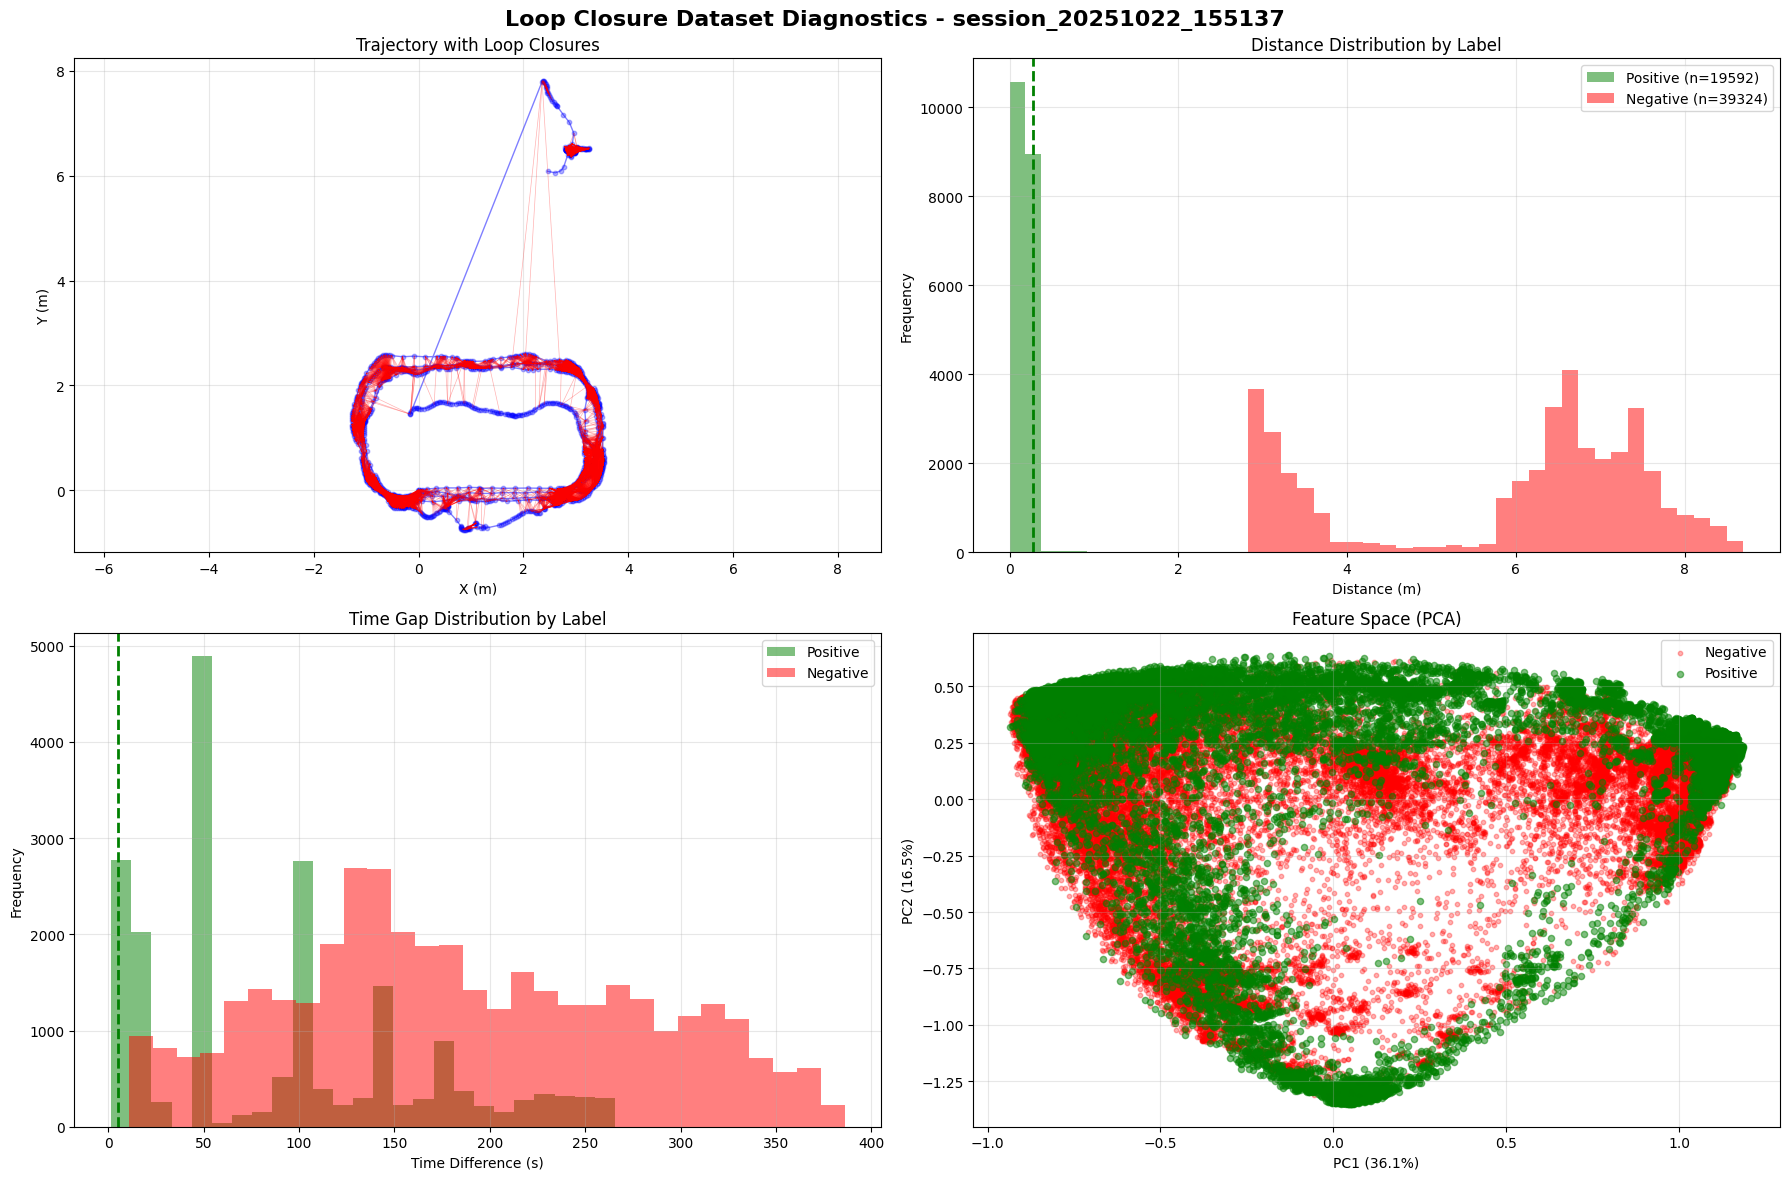

In [78]:
print("\n" + "="*70)
print("DIAGNOSTIC VISUALIZATIONS")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle(f'Loop Closure Dataset Diagnostics - {SESSION_ID}', fontsize=16, fontweight='bold')

# Plot 1: Trajectory with loop closures
ax = axes[0, 0]
traj_x = df_trajectory['x_m'].values
traj_y = df_trajectory['y_m'].values
ax.plot(traj_x, traj_y, 'b-', alpha=0.5, linewidth=1, label='Trajectory')
ax.scatter(traj_x, traj_y, c='blue', s=10, alpha=0.3)

# Highlight positive pairs
for pair in train_dataset + val_dataset + test_dataset:
    if pair['label'] == 1:
        # Note: pair dict already has node1_id and node2_id from feature assembly
        n1 = df_trajectory[df_trajectory['node_id'] == pair['node1_id']].iloc[0]
        n2 = df_trajectory[df_trajectory['node_id'] == pair['node2_id']].iloc[0]
        ax.plot([n1['x_m'], n2['x_m']], [n1['y_m'], n2['y_m']], 'r-', alpha=0.3, linewidth=0.5)

ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_title('Trajectory with Loop Closures')
ax.grid(True, alpha=0.3)
ax.axis('equal')

# Plot 2: Distance distribution by type
ax = axes[0, 1]
pos_distances = [d['distance'] for d in dataset if d['label'] == 1]
neg_distances = [d['distance'] for d in dataset if d['label'] == 0]

ax.hist(pos_distances, bins=30, alpha=0.5, label=f'Positive (n={len(pos_distances)})', color='green')
ax.hist(neg_distances, bins=30, alpha=0.5, label=f'Negative (n={len(neg_distances)})', color='red')
ax.axvline(POSITIVE_DISTANCE_THRESHOLD, color='green', linestyle='--', linewidth=2)
ax.set_xlabel('Distance (m)')
ax.set_ylabel('Frequency')
ax.set_title('Distance Distribution by Label')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Time difference distribution
ax = axes[1, 0]
pos_times = [d['time_diff'] for d in dataset if d['label'] == 1]
neg_times = [d['time_diff'] for d in dataset if d['label'] == 0]

ax.hist(pos_times, bins=30, alpha=0.5, label=f'Positive', color='green')
ax.hist(neg_times, bins=30, alpha=0.5, label=f'Negative', color='red')
ax.axvline(POSITIVE_TIME_GAP, color='green', linestyle='--', linewidth=2)
ax.set_xlabel('Time Difference (s)')
ax.set_ylabel('Frequency')
ax.set_title('Time Gap Distribution by Label')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: Feature space (PCA)
ax = axes[1, 1]
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

pos_mask = y == 1
ax.scatter(X_pca[~pos_mask, 0], X_pca[~pos_mask, 1], c='red', alpha=0.3, s=10, label='Negative')
ax.scatter(X_pca[pos_mask, 0], X_pca[pos_mask, 1], c='green', alpha=0.5, s=20, label='Positive')
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
ax.set_title('Feature Space (PCA)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()

# Save figure
DIAGNOSTICS_FILE = os.path.join(BASE_PATH, 'dataset', 'dataset_diagnostics.png')
plt.savefig(DIAGNOSTICS_FILE, dpi=150, bbox_inches='tight')
print(f"\n✅ Diagnostic plots saved: {DIAGNOSTICS_FILE}")

plt.show()

### 8.4 Text Report

In [79]:
print("Generating final report...")

output_filename = os.path.basename(DATASET_FILE)

report = f"""
{'='*70}
LOOP CLOSURE DATASET GENERATION REPORT
{'='*70}

SESSION INFORMATION:
  • Session ID: {SESSION_ID}
  • Generation date: {np.datetime64('today')}
  • Pipeline version: 6.2
  • Random seed: {RANDOM_SEED}

INPUT DATA:
  • Trajectory nodes: {len(df_trajectory)}
  • Valid nodes (both modalities): {len(complete_alignments)}
  • Camera features: {len(camera_features)} (aligned: {alignment_stats['camera_aligned']}, {100*alignment_stats['camera_aligned']/len(df_trajectory):.1f}%)
  • LiDAR features: {len(lidar_features)} (aligned: {alignment_stats['lidar_aligned']}, {100*alignment_stats['lidar_aligned']/len(df_trajectory):.1f}%)
  • INTER_SUBMAP constraints: {len(loop_closure_pairs)} (validated: {len(loop_closure_pairs)})

DATASET COMPOSITION:
  • Total pairs: {len(dataset)}
  • Positive pairs: {len(labeled_pairs_positive)} ({100*len(labeled_pairs_positive)/len(dataset):.1f}%)
  • Easy negative pairs: {len(labeled_pairs_easy)} ({100*len(labeled_pairs_easy)/len(dataset):.1f}%)
  • Hard negative pairs: {len(labeled_pairs_hard)} ({100*len(labeled_pairs_hard)/len(dataset):.1f}%)

TRAIN/VAL/TEST SPLITS (STRATIFIED RANDOM):
  • Train: {len(train_dataset)} pairs ({100*len(train_dataset)/len(dataset):.1f}%)
      → Positive: {sum(d['label'] for d in train_dataset)} ({100*train_pos_ratio:.1f}%)
  • Validation: {len(val_dataset)} pairs ({len(val_dataset)/len(dataset):.1%})
      → Positive: {sum(d['label'] for d in val_dataset)} ({100*val_pos_ratio:.1f}%)
  • Test: {len(test_dataset)} pairs ({100*len(test_dataset)/len(dataset):.1f}%)
      → Positive: {sum(d['label'] for d in test_dataset)} ({100*test_pos_ratio:.1f}%)
  • Stratification quality: {max_deviation:.3f} max deviation (< 0.05 is good)

FEATURE STATISTICS:
  • Pairwise feature dimension: {X.shape[1]}D
  • Mean: {np.mean(X):.4f}
  • Std: {np.std(X):.4f}
  • Range: [{np.min(X):.4f}, {np.max(X):.4f}]

VALIDATION STATUS:
  {'✅' if all_passed else '⚠️ ' if critical_passed else '❌'} Overall: {'PASSED' if all_passed else 'PASSED WITH WARNINGS' if critical_passed else 'FAILED'}
"""

for check_name, check_result in validation_checks:
    report += f"  {'✅' if check_result else '❌'} {check_name}\n"

report += f"""
OUTPUT FILES:
  • Dataset: {output_filename} ({file_size_mb:.2f} MB)
  • Diagnostics: dataset_diagnostics.png

NEXT STEPS:
  1. Load dataset with: pickle.load(open('{output_filename}', 'rb'))
  2. Train Fusion MLP (Phase 2): 1536→512→128→1 architecture
  3. Use BCE loss + hard negative mining
  4. Monitor validation performance
  5. Export to ONNX/TensorRT for Jetson Nano deployment


{'='*70}
"""

print(report)

# Save report
with open(REPORT_FILE, 'w') as f:
    f.write(report)

print("\n✅ Final report saved to: dataset_generation_report.txt")

print("\n" + "=" * 70)
if all_passed:
    print(" DATASET GENERATION COMPLETE - READY FOR TRAINING!")
elif critical_passed:
    print("✅ DATASET GENERATION COMPLETE - USABLE WITH WARNINGS")
else:
    print("⚠️  DATASET GENERATION COMPLETE - REVIEW VALIDATION ISSUES")
print("=" * 70)

Generating final report...

LOOP CLOSURE DATASET GENERATION REPORT

SESSION INFORMATION:
  • Session ID: session_20251022_155137
  • Generation date: 2025-11-13
  • Pipeline version: 6.2
  • Random seed: 42

INPUT DATA:
  • Trajectory nodes: 1255
  • Valid nodes (both modalities): 1242
  • Camera features: 7193 (aligned: 1242, 99.0%)
  • LiDAR features: 2973 (aligned: 1255, 100.0%)
  • INTER_SUBMAP constraints: 406 (validated: 406)

DATASET COMPOSITION:
  • Total pairs: 58916
  • Positive pairs: 19728 (33.5%)
  • Easy negative pairs: 14795 (25.1%)
  • Hard negative pairs: 24660 (41.9%)

TRAIN/VAL/TEST SPLITS (STRATIFIED RANDOM):
  • Train: 35360 pairs (60.0%)
      → Positive: 11758 (33.3%)
  • Validation: 11777 pairs (20.0%)
      → Positive: 3911 (33.2%)
  • Test: 11779 pairs (20.0%)
      → Positive: 3923 (33.3%)
  • Stratification quality: 0.000 max deviation (< 0.05 is good)

FEATURE STATISTICS:
  • Pairwise feature dimension: 3072D
  • Mean: 0.0217
  • Std: 0.0288
  • Range: [0.0

### 8.3 Dataset saving

In [80]:
print("Saving dataset...")

# Package dataset
dataset_package = {
    'train': train_dataset,
    'val': val_dataset,
    'test': test_dataset,
    'metadata': {
        'session_id': SESSION_ID,
        'creation_date': str(np.datetime64('today')),
        'num_trajectory_nodes': len(df_trajectory),
        'num_valid_nodes': len(complete_alignments),
        'num_constraints': len(loop_closure_pairs),
        'feature_dim': X.shape[1],
        'random_seed': RANDOM_SEED,
        'config': {
            'max_time_offset': MAX_TIME_OFFSET,
            'positive_distance_threshold': POSITIVE_DISTANCE_THRESHOLD,
            'easy_negative_min_distance': EASY_NEGATIVE_MIN_DISTANCE,
            'hard_negative_min_distance': HARD_NEGATIVE_MIN_DISTANCE,
            'hard_negative_similarity_threshold': HARD_NEGATIVE_SIMILARITY_THRESHOLD,
            'max_constraint_residual': MAX_CONSTRAINT_RESIDUAL,
            'max_angular_distance': MAX_ANGULAR_DISTANCE
        }
    }
}

# Save to pickle
with open(DATASET_FILE, 'wb') as f:
    pickle.dump(dataset_package, f)

file_size_mb = os.path.getsize(DATASET_FILE) / (1024 * 1024)
print(f"\n✅ Dataset saved: {DATASET_FILE}")
print(f"   File size: {file_size_mb:.2f} MB")

Saving dataset...

✅ Dataset saved: dataset/loop_closure_dataset.pkl
   File size: 694.76 MB
